## Architecture


### Lib

In [1]:

# Util #
import pickle
import numpy as np
import os
import scipy.sparse as sp
import torch
from scipy.sparse import linalg
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

# Layer #
from __future__ import division
import torch
import torch.nn as nn
from torch.nn import init
import numbers
import torch.nn.functional as F

# Model #
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys

# Trainer #
import torch.optim as optim
import math

# Main #
import torch
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt


from torch.utils.tensorboard import SummaryWriter

### Util

In [2]:

class DataLoaderM(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True):
        """
        :param xs:
        :param ys:
        :param batch_size:
        :param pad_with_last_sample: pad with the last sample to make number of samples divisible to batch_size.
        """
        self.batch_size = batch_size
        self.current_ind = 0

        # 將資料長度補齊至batch_size可整除之數量
        # 補齊方法: 取原資料最後一個並複製多個來補齊
        if pad_with_last_sample:
            # 計算需補齊數量
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)

            # 將複製後的ele進行concatenate以補齊成可整除batch_size之長度
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        self.xs = xs
        self.ys = ys

    '''
    def shuffle(self):
        permutation = np.random.permutation(self.size)
        xs, ys = self.xs[permutation], self.ys[permutation]
        self.xs = xs
        self.ys = ys
    '''
    #**fusion**#
    def set_permutation(self, permutation):
        assert len(permutation) == self.size, "Permutation length must match data size"
        self.xs = self.xs[permutation]
        self.ys = self.ys[permutation]


    def get_iterator(self):
        self.current_ind = 0
        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.batch_size * self.current_ind
                end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
                x_i = self.xs[start_ind: end_ind, ...]
                y_i = self.ys[start_ind: end_ind, ...]
                # 節省記憶體:
                # yield 設計來的目的，就是為了單次輸出內容
                # 我們可以把 yield 暫時看成 return，但是這個 return 的功能只有單次
                # 而且，一旦我們的程式執行到 yield 後，程式就會把值丟出，並暫時停止
                yield (x_i, y_i)
                self.current_ind += 1

        return _wrapper()

class StandardScaler():
    """
    Standard the input
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def transform(self, data):
        return (data - self.mean) / self.std
    def inverse_transform(self, data):
        return (data * self.std) + self.mean

def asym_adj(adj):
    """Asymmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv = np.power(rowsum, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat= sp.diags(d_inv)
    return d_mat.dot(adj).astype(np.float32).todense()


def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

def load_adj(pkl_filename, adjtype):
    sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(pkl_filename)

    print('# 全部L.A.的sensor ID(sensor_ids):\n',sensor_ids)
    print('# 將sensor ID對應index(sensor_id_to_ind):\n',sensor_id_to_ind)

    if adjtype == "scalap":
        adj = [calculate_scaled_laplacian(adj_mx)]
    elif adjtype == "normlap":
        adj = [calculate_normalized_laplacian(adj_mx).astype(np.float32).todense()]
    elif adjtype == "symnadj":
        adj = [sym_adj(adj_mx)]
    elif adjtype == "transition":
        adj = [asym_adj(adj_mx)]
    elif adjtype == "doubletransition":
        adj = [asym_adj(adj_mx), asym_adj(np.transpose(adj_mx))]   # asym_adj(adj_mx): forward transition matrix / asym_adj(np.transpose(adj_mx)): backward transition matrix
    elif adjtype == "identity":
        adj = [np.diag(np.ones(adj_mx.shape[0])).astype(np.float32)]
    else:
        error = 0
        assert error, "adj type not defined"

    print('# Double transition Transition matrix of Eq 4:\n',adj)
    return sensor_ids, sensor_id_to_ind, adj


def masked_mse(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels!=null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = (preds-labels)**2
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

def masked_rmse(preds, labels, null_val=np.nan):
    return torch.sqrt(masked_mse(preds=preds, labels=labels, null_val=null_val))


def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels!=null_val)
    mask = mask.float()
    mask /=  torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds-labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)
def masked_mape(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels!=null_val)
    mask = mask.float()
    mask /=  torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds-labels)/labels
    #loss = 2.0 * torch.mean(torch.abs(preds - labels) / (torch.abs(preds) + torch.abs(labels)))
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)
def masked_smape(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels!=null_val)
    mask = mask.float()
    mask /=  torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    #loss = torch.abs(preds-labels)/labels
    loss = 2.0 * (torch.abs(preds - labels) / (torch.abs(preds) + torch.abs(labels)))
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

def metric(pred, real):
    mae = masked_mae(pred,real,0.0).item()
    mape = masked_mape(pred,real,0.0).item()
    rmse = masked_rmse(pred,real,0.0).item()
    smape = masked_smape(pred,real,0.0).item()
    return mae,mape,rmse,smape

### Layer

In [3]:

# GWNET
class nconv2(nn.Module):
    def __init__(self):
        super(nconv2,self).__init__()

    def forward(self,x, A):
        # x: torch.Size([64, 32, 207, 12])
        # A: torch.Size([207, 207])
        x = torch.einsum('ncvl,vw->ncwl',(x,A))
        return x.contiguous()


class linear(nn.Module):
    def __init__(self,c_in,c_out,bias=True):
        super(linear,self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(1, 1), padding=(0,0), stride=(1,1), bias=bias)

    def forward(self,x):
        return self.mlp(x)



# Process the input with the Adj matrix #
class gcn(nn.Module):
    def __init__(self,model_type, adj_mx_len,  c_in,c_out,gdep,dropout,alpha):
        super(gcn, self).__init__()

        self.model_type = model_type
        self.adj_mx_len = adj_mx_len

        # 這裡要實驗看看
        if self.model_type == "GWNET":
            self.nconv = nconv2()

        c_in = (gdep*adj_mx_len+1)*c_in
        self.mlp = linear(c_in,c_out)
        self.gdep = gdep
        self.dropout = dropout
        self.alpha = alpha

    def forward(self,x,adj):


        h = x
        out = [h]

        if self.model_type == "GWNET":
            # support: 儲存adj matrix/transpose adj matrix/adaptive matrix(optional)
            for a in adj:
                # 執行diffision convl 第1層
                x1 = self.nconv(x,a)                                  # 將各sensor的值透過adj matrix進行聚合
                out.append(x1)

                # 執行diffusion convl 第k層 (1<k<=2)
                # Paper的diffusion step= 2
                # k=0: P*a=x1
                # k=1: P*(x1)=P*(P*a)=P^2*a
                for k in range(2, self.gdep + 1):
                    x2 = self.nconv(x1,a)
                    out.append(x2)
                    x1 = x2

        # 問題: 原論文是將每個H經過MLP後, 最後進行加總
        # 可能因為過多MLP層, 故作者將H先串接, 最後將dim=1展開, 再經過MLP
        # [1+depth layer] -- cat -> ([64, 96, 207, 13]) -- MLP-> ([64, 32, 207, 13])
        ho = torch.cat(out,dim=1)   # torch.Size([64, 96, 207, ?])
        ho = self.mlp(ho)

        # Paper step: information propagation step -- END #
        return ho


# dilated_inception: 有[2,3,6,7]4個平行層 => 分別處理後再串接 #
class dilated_inception(nn.Module):
    def __init__(self, kernel_set, cin, cout, dilation_factor=2):
        super(dilated_inception, self).__init__()
        self.tconv = nn.ModuleList()
        self.kernel_set = kernel_set
        cout = int(cout/len(self.kernel_set))    # 32/4 = 8

        # (1x2) & (1x3) & (1x6) & (1x7)
        for kern in self.kernel_set:
            self.tconv.append(nn.Conv2d(cin,cout,(1,kern),dilation=(1,dilation_factor)))

    def forward(self,input):
        if args.log_print:
            print("# dilated_inception input", input.shape)

        x = []

        # 每層拿"原"input, 而非處理後的input
        # ex:
        # kernel_set: 2 -> torch.Size([64, 8, 207, 18])
        # kernel_set: 3 -> torch.Size([64, 8, 207, 17])
        # kernel_set: 6 -> torch.Size([64, 8, 207, 14])
        # kernel_set: 7 -> torch.Size([64, 8, 207, 13])
        for i in range(len(self.kernel_set)):

            x.append(self.tconv[i](input))

            if args.log_print:
              print('# kernel_set:', self.kernel_set[i])
              print('# self.tconv[i](input):', self.tconv[i](input).shape)

        # 依照最後一層的feature dim(-x[-1].size(3)), 縮減各層的dim
        # 各層feature只取: [..., -x[-1].size(3): ]
        for i in range(len(self.kernel_set)):

            if args.log_print:
              print('# kernel_set:', self.kernel_set[i])
              print('# x[i].shape', x[i].shape)
              print('# -x[-1].size(3)', -x[-1].size(3))

            x[i] = x[i][...,-x[-1].size(3):]
            if args.log_print:
              print('# modeified x[i].shape', x[i].shape)

        # 8x4 kernel set => (64, 32, 207, 13)
        x = torch.cat(x,dim=1)
        if args.log_print:
          print("# final x", x.shape)
        #sys.exit()
        return x

# Paper's graph adjacency matrix
class graph_adaptive(nn.Module):
    # k: subgraph size
    def __init__(self, model_type, nnodes, k, dim, device, alpha=3, static_feat=None):
        super(graph_adaptive, self).__init__()

        self.model_type = model_type
        self.nnodes = nnodes
        '''
        if static_feat is not None:
            xd = static_feat.shape[1]
            self.lin1 = nn.Linear(xd, dim)
            self.lin2 = nn.Linear(xd, dim)
        else:
        '''

        if self.model_type == "GWNET":
            # Paper: "..initialize node embeddings by a uniform distribution with a size of 10."
            self.nodevec1 = nn.Parameter(torch.randn(self.nnodes, 10).to(device), requires_grad=True).to(device)
            self.nodevec2 = nn.Parameter(torch.randn(10, self.nnodes).to(device), requires_grad=True).to(device)

        self.device = device
        self.k = k
        self.dim = dim
        self.alpha = alpha
        self.static_feat = static_feat

    def forward(self, idx=None):   # idx: 已打亂順序的index
        if self.model_type == "GWNET":
            adj = F.softmax(F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)  # SoftMax(ReLU(E1*E2^T))

        return adj


class LayerNorm(nn.Module):
    __constants__ = ['normalized_shape', 'weight', 'bias', 'eps', 'elementwise_affine']
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super(LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = tuple(normalized_shape)
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.Tensor(*normalized_shape))
            self.bias = nn.Parameter(torch.Tensor(*normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        self.reset_parameters()


    def reset_parameters(self):
        if self.elementwise_affine:
            init.ones_(self.weight)
            init.zeros_(self.bias)

    def forward(self, input, idx):
        if self.elementwise_affine:
            return F.layer_norm(input, tuple(input.shape[1:]), self.weight[:,idx,:], self.bias[:,idx,:], self.eps)
        else:
            return F.layer_norm(input, tuple(input.shape[1:]), self.weight, self.bias, self.eps)

    def extra_repr(self):
        return '{normalized_shape}, eps={eps}, ' \
            'elementwise_affine={elementwise_affine}'.format(**self.__dict__)

### MGAT for fusion

In [4]:
import numpy as np

def create_matrix(n, k):
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(k):
            if i-j >= 0:
                mat[i][i-j] = 1
    return mat


def pearson_corr2(tensor): # all: (64,1,n,dim)
  # Input tensor shape: (batch_size, num_nodes, time_steps)
  batch_size, num_nodes, _ = tensor.shape
  tensor = tensor - tensor.mean(dim=2, keepdim=True)
  std = tensor.std(dim=2, keepdim=True)
  tensor = tensor / (std + 1e-8)
  correlation_matrix = torch.matmul(tensor, tensor.transpose(1, 2))
  correlation_matrix = correlation_matrix / (tensor.shape[2] - 1)
  return correlation_matrix


def topK(attn, top_num ):

  # Get the top K values and their indices for each row
  top_k_values, top_k_indices = attn.topk(top_num, dim=3)

  # Create a mask with the same shape as the input tensor, filled with zeros
  mask = torch.zeros_like(attn)

  # Set the top K values in the mask to 1
  mask.scatter_(3, top_k_indices, 1)

  # Multiply the input tensor with the mask to get the result
  attn = attn * mask

  return  attn


# this efficient implementation comes from https://github.com/xptree/DeepInf/
class S_BatchMultiHeadGraphAttention(nn.Module):
    def __init__(self, n_heads, num_nodes, dropout, bias=True):
        super(S_BatchMultiHeadGraphAttention, self).__init__()

        print('S_BatchMultiHeadGraphAttention', n_heads, num_nodes, dropout)
        self.n_head = n_heads
        self.f_in = num_nodes
        #self.w = nn.Parameter(torch.Tensor(self.n_head, num_nodes, num_nodes))
        self.a_src = nn.Parameter(torch.Tensor(self.n_head*2, num_nodes, 1))
        self.a_dst = nn.Parameter(torch.Tensor(self.n_head*2, num_nodes, 1))

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_nodes))
            nn.init.constant_(self.bias, 0)
        else:
            self.register_parameter("bias", None)


        nn.init.xavier_uniform_(self.a_src, gain=1.414)
        nn.init.xavier_uniform_(self.a_dst, gain=1.414)

        self.W_si = nn.Parameter(torch.zeros(size=(1, 1)))
        nn.init.xavier_uniform_(self.W_si.data, gain=1.414)
        self.W_ei = nn.Parameter(torch.zeros(size=(1, 1)))
        nn.init.xavier_uniform_(self.W_ei.data, gain=1.414)

    def forward(self, h, a):

        bs, ch, n, dim = h.size()
        #h_prime = torch.matmul(h, self.w)
        h_prime = h
        attn_src = torch.matmul(torch.tanh(h), self.a_src)
        attn_dst = torch.matmul(torch.tanh(h), self.a_dst)
        attn = attn_src.expand(-1, -1, -1, n) + attn_dst.expand(-1, -1, -1, n).permute(
            0, 1, 3, 2
        )

        attn_2 = self.leaky_relu(attn)
        attn_2 = self.softmax(attn_2)
        attn_2 = self.dropout(attn_2)

        attn_2 = abs(self.W_ei)*attn_2+abs(self.W_si)*a

        output_2 = torch.matmul(attn_2, h_prime)

        return output_2, attn

# MutiChannel_GAT(kern, dilation_factor, n_heads, num_nodes, mlp, mlp2, dropout)
class S_MutiChannel_GAT(nn.Module):
    def __init__(self, kern, dilation_factor, n_heads, num_nodes, mlp, mlp2, dropout):
        super(S_MutiChannel_GAT, self).__init__()

        print('S_MutiChannel_GAT', n_heads, num_nodes, dropout)

        self.gat_layer = S_BatchMultiHeadGraphAttention(
            n_heads, num_nodes, dropout
        )
        self.gat_layer2 = S_BatchMultiHeadGraphAttention(
            n_heads, num_nodes, dropout
        )

        self.mlp1 =  nn.Conv2d(in_channels=32,
                                    out_channels=16,
                                    kernel_size=(1, 1))

        self.mlp2 =  nn.Conv2d(in_channels= 32,
                                    out_channels=32,
                                    kernel_size=(1, 1))

    def forward(self,x1, x2, a_f):

        bs,ch,n,dim = x1.shape
        x_all = []

        filtered_indices = [index for index in args.all_idx if index not in args.exclue_idx]
        cam_seen = x2[:,:,filtered_indices]

        filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w not in args.exclue_idx]
        for idx in range(n):

          # concat current GCT + cam_seen
          x_input = [x1[:,:,idx].unsqueeze(2), cam_seen]
          x_input = torch.cat(x_input, dim=2) # 64,32,7,19

          # encoder
          x = self.mlp1(x_input)

          # extract corresponding matrix
          temp_filtered_corre_indices = filtered_corre_indices.copy()
          # Insert the new idx at the beginning of the temporary list
          temp_filtered_corre_indices.insert(0, idx)

          new_matrix = a_f[np.ix_(temp_filtered_corre_indices, temp_filtered_corre_indices)]

          # fusion
          x_input, attn = self.gat_layer(x,new_matrix)

          # decoder
          x_out = self.mlp2(torch.cat([x[:,:,0].unsqueeze(2),x_input[:,:,0].unsqueeze(2)],dim=1))

          x_all.append(x_out)

        x_out = torch.cat(x_all, dim=2)  # (64,32,48,19)

        return x_out


### Model .00001 ~ .0001

In [5]:
class gginet(nn.Module):
    def __init__(self, model_type, gcn_true, buildA_true, gcn_depth, num_nodes, device, predefined_A=None,kernel_set=None, static_feat=None, dropout=0.3, subgraph_size=20, node_dim=40, dilation_exponential=1, conv_channels=32, residual_channels=32, skip_channels=64, end_channels=128, seq_length=12, in_dim=2, out_dim=12, layers=3, propalpha=0.05, tanhalpha=3, layer_norm_affline=True, fusion=None):
        super(gginet, self).__init__()

        self.model_type = model_type

        self.gcn_true = gcn_true
        self.buildA_true = buildA_true
        self.num_nodes = num_nodes
        self.dropout = dropout
        self.predefined_A = predefined_A
        self.layers = layers
        self.seq_length = seq_length

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.gconv1 = nn.ModuleList()
        self.gconv2 = nn.ModuleList()
        self.norm = nn.ModuleList()
        self.start_conv = nn.Conv2d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=(1, 1))


        if fusion != None:  #********#

          self.fusion_list = nn.ModuleList()
          in_channel = 32
          n_heads = 8
          dropout = 0
          alpha = 0.2
          t_len = 13

          kern = 2
          dilation_factor = 1
          n_heads = 8
          target_len = t_len
          self.fusion_list.append(S_MutiChannel_GAT(kern, dilation_factor, n_heads, target_len, [24,16,8], [16,24,32], dropout))




        # 一整個gtnet只會有一組node embedding E1,E2
        self.adaptive_mx = graph_adaptive(self.model_type, num_nodes, subgraph_size, node_dim, device, alpha=tanhalpha, static_feat=static_feat)


        if self.model_type == "GWNET":
            kernel_size = 2
            self.receptive_field = int((layers/2)* ( (kernel_size-1)+ kernel_size ) + 1)    # kernel: 1,2,1,2...

        print("# Model Type", self.model_type)
        print("# receptive_field", self.receptive_field)
        i=0
        if dilation_exponential>1:
            rf_size_i = int(1 + i*(kernel_size-1)*(dilation_exponential**layers-1)/(dilation_exponential-1))
        else:
            rf_size_i = i*layers*(kernel_size-1)+1
        new_dilation = 1
        for j in range(1,layers+1):

            if self.model_type == "GWNET":
                if j % 2 == 1:
                    new_dilation = 1
                elif j % 2 == 0:
                    new_dilation = 2

            # residual_channels: 32, conv_channels: 32 , new_dilation: 1
            self.filter_convs.append(dilated_inception(kernel_set, residual_channels, conv_channels, dilation_factor=new_dilation))
            self.gate_convs.append(dilated_inception(kernel_set, residual_channels, conv_channels, dilation_factor=new_dilation))


            # 1x1 convolution for skip connection
            #(0): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
            #(1): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
            #(2): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
            #...
            if self.model_type == "GWNET" :
                self.skip_convs.append(nn.Conv2d(in_channels=conv_channels,
                                        out_channels=skip_channels,
                                        kernel_size=(1, 1)))

            #####   GCN   ##### START
            if self.gcn_true:
                if self.model_type == "GWNET":
                    if self.buildA_true:    # 有加入adaptive matrix
                        adj_mx_len = 3
                    else:
                        adj_mx_len = 2
                    self.gconv1.append(gcn(self.model_type, adj_mx_len, conv_channels, residual_channels, gcn_depth, dropout, propalpha))


            else:
                self.residual_convs.append(nn.Conv2d(in_channels=conv_channels,
                                                out_channels=residual_channels,
                                              kernel_size=(1, 1)))

            #####   GCN   ##### END

            #####   Normalization   ##### START
            if self.model_type == "GWNET":
                self.norm.append(nn.BatchNorm2d(residual_channels))
            #####   Normalization   ##### END

            new_dilation *= dilation_exponential



        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                             out_channels=end_channels,
                                             kernel_size=(1,1),
                                             bias=True)
        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                             out_channels=out_dim,
                                             kernel_size=(1,1),
                                             bias=True)



        self.idx = torch.arange(self.num_nodes).to(device)

        if fusion != None:  #********#
          self.W_f1 = nn.Parameter(torch.FloatTensor(1, 1).uniform_(0.00001, 0.0001))
          self.W_f2 = nn.Parameter(torch.FloatTensor(1, 1).uniform_(0.00001, 0.0001))



    def forward(self, input, idx=None, input_2=None):

        seq_len = input.size(3)
        assert seq_len==self.seq_length, 'input sequence length not equal to preset sequence length'

        # Step0: 檢查receptive_field, 不足則padding0
        if self.seq_length<self.receptive_field:
            input = nn.functional.pad(input,(self.receptive_field-self.seq_length,0,0,0))

            if input_2 != None:   #********#
              input_2 = nn.functional.pad(input_2,(self.receptive_field-self.seq_length,0,0,0))

        # Step0: 利用node idx建立embedding:E1, E2
        # 建立Sparse的Adaptive matrix
        if self.gcn_true:

            # Use adaptive matrix
            if self.buildA_true:
                if self.model_type == "GWNET":
                    adp = self.adaptive_mx()
                    adp = self.predefined_A + [adp]


            else:
                adp = self.predefined_A

        if self.model_type == "GWNET":
            skip = 0

        if input_2 != None:  #********#
            x_all = []
            corre_idx_selected = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w not in args.exclue_idx]
            all_idx_selected = [index for index in args.all_idx if index not in args.exclue_idx]

            _count = 0
            for i in range(49):
              if i in corre_idx_selected:
                x_all.append(input_2[:,:, all_idx_selected[_count]].unsqueeze(2))
                _count+=1
              else:
                x_all.append(input[:,:,i].unsqueeze(2))
            x = torch.cat(x_all,2)

            x = self.start_conv(x)
        else:
          # Step1: turn([64, 2, 207, 19]) to ([64, 32, 207, 19])
          x = self.start_conv(input)      # gct


        if input_2 != None:   #********#
            x2 = self.start_conv(input_2)   # cctv
            x = self.fusion_list[0](x,x2,adj_mx_gct[0])


        # Layers : 3層 : 19->13->7->1 (取決於TCN取的維度)
        for i in range(self.layers):

            # Step2: Temporal Model --START #
            # 為上一層輸出, ex:  [64, 32, 207, 19] -> [64, 32, 207, 13] -> [64, 32, 207, 7]-> [64, 32, 207, 1]
            residual = x

            # Tanh
            filter = self.filter_convs[i](x)
            filter = torch.tanh(filter)

            # Sigmoid
            gate = self.gate_convs[i](x)
            gate = torch.sigmoid(gate)

            # Fusion
            x = filter * gate

            # Step2: Temporal Model --END #

            # Step3: Skip after TCN --START #
            s = x
            '''
            # skip_convs #
            (0): Conv2d(32, 64, kernel_size=(1, 13), stride=(1, 1))
            (1): Conv2d(32, 64, kernel_size=(1, 7), stride=(1, 1))
            (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
            '''
            # fusion output:([64, 32, 207, 13])
            # skip_convsL 0:([64, 64, 207, 1])
            s = self.skip_convs[i](s)

            if self.model_type == "GWNET":
                # 讓上一個skip配合目前的skip
                try:
                    skip = skip[:, :, :,  -s.size(3):]
                except:
                    skip = 0

            skip = s + skip

            # Step3: Skip after TCN --END #


            # Step4: GCN --START #
            if self.gcn_true:
                if self.model_type == "GWNET":
                    x = self.gconv1[i](x, adp)

            else:
                x = self.residual_convs[i](x)

            # x 經過dilated處理後, 會減少feature維度, ex: 19->13->7->1
            # 而residual為上一層輸出, 維度為: 19, 13 ...
            # 所以需要配合x進行維度調整: [:, :, :, -x.size(3):], 然後進行elemenet-wise相加
            x = x + residual[:, :, :, -x.size(3):]


            if self.model_type == "GWNET":
                x = self.norm[i](x)

            # Step4: GCN --END #


        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)
        return x

### Trainer  

In [6]:
class Trainer():
    def __init__(self, model,model_2, model_3, lrate, wdecay, clip, step_size, seq_out_len, scaler, scaler_2, device, cl=True):

        # GCT
        self.scaler = scaler
        self.model = model
        self.model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lrate, weight_decay=wdecay)

        # CCTV
        self.scaler_2 = scaler_2
        self.model_2 = model_2
        self.model_2.to(device)
        self.optimizer_2 = optim.Adam(self.model_2.parameters(), lr=lrate, weight_decay=wdecay)

        # Fusion
        self.model_3 = model_3
        self.model_3.to(device)
        self.optimizer_3 = optim.Adam(self.model_3.parameters(), lr=lrate, weight_decay=wdecay)

        self.loss = masked_mae
        self.clip = clip
        self.step = step_size
        self.iter = 1
        self.task_level = 1
        self.seq_out_len = seq_out_len
        self.cl = cl



    # input: GCT, input_2: CCTV, real_val: gct
    def train(self, input,input_2, real_val, real_val_2, idx=None):
        # torch.Size([64, 2, 49, 12]) torch.Size([64, 2, 6, 12]) torch.Size([64, 49, 12]) torch.Size([64, 6, 12])
        #print('input,input_2, real_val, real_val_2', input.shape,input_2.shape, real_val.shape, real_val_2.shape)  # torch.Size([64, 2, 49, 12]) torch.Size([64, 2, 6, 12])


        self.model.eval()
        self.model_2.eval()

        output = self.model(input)
        output = output.transpose(1,3)
        output_2 = self.model_2(input_2)
        output_2 = output_2.transpose(1,3)

        output = torch.cat([output,input[:,1].unsqueeze(1)],dim=1)
        output_2 = torch.cat([output_2,input_2[:,1].unsqueeze(1)],dim=1)

        self.model_3.train()  #*******#
        self.optimizer_3.zero_grad()  #*******#
        output = self.model_3(output, idx=idx, input_2=output_2) #*******#
        output = output.transpose(1,3)  # torch.Size([64, 2, 49, 12])

        real_1 = torch.unsqueeze(real_val,dim=1)   # torch.Size([64, 49, 12])
        real_2 = torch.unsqueeze(real_val_2,dim=1) # torch.Size([64, 6, 12])

        predict = self.scaler.inverse_transform(output) # torch.Size([64, 49, 12])

        #------------------主要預測點位逼近影像-----------------#
        filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w not in args.exclue_idx]
        #indices = torch.tensor(filtered_corre_indices).cuda()
        #selected_predict = torch.index_select(predict, 2, indices)
        selected_predict = predict[:,:,filtered_corre_indices]

        filtered_indices = [index for index in args.all_idx if index not in args.exclue_idx]
        selected_real = real_2[:,:,filtered_indices]

        predict1 = selected_predict
        real1 = selected_real

        if self.iter%self.step==0 and self.task_level<=self.seq_out_len:
            self.task_level +=1
            print("### cl learning\n iter",self.iter,"\niter%step",self.iter%self.step,"\ntask_level",self.task_level)
            print("# predict1(GCT->video) len:", len(predict1[:, :, :, :self.task_level]))
            #print(" ####### dynamic fusion weight", self.model_3.W_f1, self.model_3.W_f2)


        if self.cl:
            loss1 = masked_mae(predict1[:, :, :, :self.task_level], real1[:, :, :, :self.task_level], 0.0)
            loss_mape_1 = masked_mape(predict1[:, :, :, :self.task_level], real1[:, :, :, :self.task_level], 0.0)
            loss_rmse_1 = masked_rmse(predict1[:, :, :, :self.task_level], real1[:, :, :, :self.task_level], 0.0)
            loss_smape_1 = masked_smape(predict1[:, :, :, :self.task_level], real1[:, :, :, :self.task_level], 0.0)

        else:
            loss1 = masked_mae(predict1, real1, 0.0)

            loss_mape_1 =  masked_mape(predict1, real1, 0.0)
            loss_rmse_1 =  masked_rmse(predict1, real1, 0.0)
            loss_smape_1 =  masked_smape(predict1, real1, 0.0)



        #------------------其他逼近GCT-----------------#
        numbers_0_to_48 = list(range(49))
        excluded_numbers_args = args.corre_idx
        not_seen = [num for num in numbers_0_to_48 if num not in excluded_numbers_args]

        indices = torch.tensor(not_seen).cuda()

        selected_predict = predict[:,:,indices]
        selected_real = real_1[:,:,not_seen]

        predict1_1 = selected_predict
        real1_1 = selected_real

        if self.cl:
            loss1_1 = masked_mae(predict1_1[:, :, :, :self.task_level], real1_1[:, :, :, :self.task_level], 0.0)

        else:
            loss1_1 = masked_mae(predict1_1, real1_1, 0.0)


        #------------------main unseen GCT-----------------#
        not_seen = args.exclue_idx

        indices = torch.tensor(not_seen).cuda()

        selected_predict = predict[:,:,indices]
        selected_real = real_1[:,:,not_seen]

        predict1_2 = selected_predict
        real1_2 = selected_real

        if self.cl:
            loss1_2 = masked_mae(predict1_2[:, :, :, :self.task_level], real1_1[:, :, :, :self.task_level], 0.0)

        else:
            loss1_2 = masked_mae(predict1_2, real1_2, 0.0)

        #------------------unseen點位誤差-----------------#

        filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w  in args.exclue_idx]
        #indices = torch.tensor(filtered_corre_indices).cuda()
        #selected_predict = torch.index_select(predict, 2, indices)
        selected_predict = predict[:,:,filtered_corre_indices]

        filtered_indices = [index for index in args.all_idx if index in args.exclue_idx]
        selected_real = real_2[:,:,filtered_indices]


        predict2 = selected_predict
        real2 = selected_real

        if self.cl:
            loss2 = masked_mae(predict2[:, :, :, :self.task_level], real2[:, :, :, :self.task_level], 0.0)

            loss_mape_2 = masked_mape(predict2[:, :, :, :self.task_level], real2[:, :, :, :self.task_level], 0.0)
            loss_rmse_2 = masked_rmse(predict2[:, :, :, :self.task_level], real2[:, :, :, :self.task_level], 0.0)
            loss_smape_2 = masked_smape(predict2[:, :, :, :self.task_level], real2[:, :, :, :self.task_level], 0.0)

        else:
            loss2 = masked_mae(predict2, real2, 0.0)

            loss_mape_2 =  masked_mape(predict2, real2, 0.0)
            loss_rmse_2 =  masked_rmse(predict2, real2, 0.0)
            loss_smape_2 =  masked_smape(predict2, real2, 0.0)

        var_w = (abs(self.model_3.W_f1)).to(loss1_1.device)
        var_w1 = (abs(self.model_3.W_f2)).to(loss1_2.device)

        loss = 1*loss1 + var_w*(loss1_1) + var_w1*(loss1_2)
        loss.backward()

        if self.clip is not None:
            torch.nn.utils.clip_grad_norm_(self.model_3.parameters(), self.clip)  #*******#

        self.optimizer_3.step() #*******#

        self.iter += 1
        return (var_w1*loss1_2.item()+var_w*loss1_1.item()).cpu().detach().numpy(), loss1.item(),loss_mape_1.item(),loss_rmse_1.item(),loss_smape_1.item(), loss2.item(),loss_mape_2.item(),loss_rmse_2.item(),loss_smape_2.item()

    def eval(self, model_type, input, real_val, input_2=None):
        #print('type',model_type)
        if model_type == 'gct':
          self.model.eval()
          output = self.model(input)
          output = output.transpose(1,3)

          predict = self.scaler.inverse_transform(output)

        elif model_type == 'cctv':
          self.model_2.eval()
          output = self.model_2(input)
          output = output.transpose(1,3)

          predict = self.scaler_2.inverse_transform(output)

        elif model_type == 'fusion':
          self.model.eval()
          self.model_2.eval()
          self.model_3.eval()

          output = self.model(input)
          output = output.transpose(1,3)
          output_2 = self.model_2(input_2)
          output_2 = output_2.transpose(1,3)

          output = torch.cat([output,input[:,1].unsqueeze(1)],dim=1)
          output_2 = torch.cat([output_2,input_2[:,1].unsqueeze(1)],dim=1)

          output = self.model_3(output, idx=None, input_2=output_2)
          output = output.transpose(1,3)

          predict = self.scaler.inverse_transform(output)

          # seen 誤差 #
          filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w not in args.exclue_idx]
          indices = torch.tensor(filtered_corre_indices).cuda()

          selected_predict1 = torch.index_select(predict, 2, indices)

          # unseen 誤差 #
          filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w  in args.exclue_idx]
          indices = torch.tensor(filtered_corre_indices).cuda()
          selected_predict2 = torch.index_select(predict, 2, indices)

        real = torch.unsqueeze(real_val,dim=1)


        if model_type == 'fusion':

          predict1 = selected_predict1
          predict2 = selected_predict2

          filtered_indices = [index for index in args.all_idx if index not in args.exclue_idx]
          selected_real = real[:,:,filtered_indices]
          real1 = selected_real

          filtered_indices = [index for index in args.all_idx if index in args.exclue_idx]
          selected_real = real[:,:,filtered_indices]
          real2 = selected_real

        if model_type != 'fusion':
          loss = self.loss(predict, real, 0.0)
          mape = masked_mape(predict,real,0.0).item()
          rmse = masked_rmse(predict,real,0.0).item()
          smape = masked_smape(predict,real,0.0).item()
          return loss.item(),mape,rmse,smape
        else:

          loss1 = self.loss(predict1, real1, 0.0)
          loss_mape_1 = masked_mape(predict1,real1,0.0)
          loss_rmse_1 = masked_rmse(predict1,real1,0.0)
          loss_smape_1 = masked_smape(predict1,real1,0.0)

          loss2 = self.loss(predict2, real2, 0.0)
          loss_mape_2 = masked_mape(predict2,real2,0.0)
          loss_rmse_2 = masked_rmse(predict2,real2,0.0)
          loss_smape_2 = masked_smape(predict2,real2,0.0)

          return loss1.item(),loss_mape_1.item(),loss_rmse_1.item(),loss_smape_1.item(), loss2.item(),loss_mape_2.item(),loss_rmse_2.item(),loss_smape_2.item()



### Parameter

In [7]:


def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')


parser = argparse.ArgumentParser()
parser.add_argument('--device',type=str,default='cuda',help='')
parser.add_argument('--adjtype',type=str,default='doubletransition',help='adj type')


parser.add_argument('--gcn_true', type=str_to_bool, default=True, help='whether to add graph convolution layer')
parser.add_argument('--buildA_true', type=str_to_bool, default=True,help='whether to construct adaptive adjacency matrix')
parser.add_argument('--cl', type=str_to_bool, default=True,help='whether to do curriculum learning')

parser.add_argument('--gcn_depth',type=int,default=2,help='graph convolution depth')
parser.add_argument('--dropout',type=float,default=0.3,help='dropout rate')

parser.add_argument('--node_dim',type=int,default=40,help='dim of nodes')
parser.add_argument('--dilation_exponential',type=int,default=1,help='dilation exponential')

parser.add_argument('--conv_channels',type=int,default=32,help='convolution channels')
parser.add_argument('--residual_channels',type=int,default=32,help='residual channels')


parser.add_argument('--in_dim',type=int,default=2,help='inputs dimension')
parser.add_argument('--seq_in_len',type=int,default=12,help='input sequence length')
parser.add_argument('--seq_out_len',type=int,default=12,help='output sequence length')


parser.add_argument('--batch_size',type=int,default=64,help='batch size')
parser.add_argument('--clip',type=int,default=5,help='clip')

parser.add_argument('--propalpha',type=float,default=0.05,help='prop alpha')
parser.add_argument('--tanhalpha',type=float,default=3,help='adj alpha')

##### GWNET's diff parameter #####
parser.add_argument('--model_type',type=str,default='GWNET',help='model type')
parser.add_argument('--skip_channels',type=int,default=256,help='skip channels')
parser.add_argument('--end_channels',type=int,default=512,help='end channels')
parser.add_argument('--layers',type=int,default=8,help='number of layers')
parser.add_argument('--kernel_set',default=[2], type=int, nargs='+')

parser.add_argument('--print_every',type=int,default=50,help='')
parser.add_argument('--seed',type=int,default=101,help='random seed')
parser.add_argument('--save',type=str,default='./save/',help='save path')

parser.add_argument('--log_print', type=str_to_bool, default=False ,help='whether to load static feature')

parser.add_argument('--learning_rate',type=float,default=0.0005,help='learning rate')
parser.add_argument('--weight_decay',type=float,default=0.0001,help='weight decay rate')

parser.add_argument('--step_size1',type=int,default=400,help='step_size')
parser.add_argument('--step_size2',type=int,default=100,help='step_size')


#------------------#

### GCT ###
target = 'hsin_49_GCT_0600_1900_rename'
parser.add_argument('--data_gct',type=str,default='../Data/'+target ,help='data path')
parser.add_argument('--adj_data_gct',type=str,default='../Data/'+target+'/adj_mat_49_corrected.pkl',help='adj data path')
parser.add_argument('--num_nodes_gct',type=int,default=49,help='number of nodes/variables')
parser.add_argument('--expid_gct',type=int,default=202312151449,help='experiment id')
parser.add_argument('--subgraph_size_gct',type=int,default=20,help='k')

### CCTV ###
target = 'hsin_9_CCTV_0600_1900_rename'
parser.add_argument('--data_cctv',type=str,default='../Data/'+target ,help='data path')
parser.add_argument('--adj_data_cctv',type=str,default='../Data/'+target+'/adj_mat_9.pkl',help='adj data path')
parser.add_argument('--num_nodes_cctv',type=int,default=9,help='number of nodes/variables')
parser.add_argument('--expid_cctv',type=int,default=202301041709,help='experiment id')
parser.add_argument('--subgraph_size_cctv',type=int,default=4,help='k')

# cam ID: 5	4	1	2	3	6	7	8	9 -> corre road ID: 45 27 5 7 16 42 37 30 22 -> corre idx: 7 21 19 17 3 15 1 6 9
parser.add_argument('--all_idx',type=int,default=[0, 1, 2, 3, 4, 5, 6, 7, 8],help='idxs')
parser.add_argument('--corre_idx',type=int,default=[7, 21, 19, 17, 3, 15, 1, 6, 9],help='idxs')
parser.add_argument('--exclue_idx',type=int,default=[4],help='idxs')

### Fusion ###
parser.add_argument('--expid_fusion',type=int,default=202401251640,help='experiment id')
parser.add_argument('--runs',type=int,default=1,help='number of runs')
parser.add_argument('--epochs',type=int,default=180,help='')

args=parser.parse_args(args=[])
torch.set_num_threads(3)

args=parser.parse_args(args=[])
print('# args', args)

device = torch.device(args.device)

writer = SummaryWriter()

# args Namespace(device='cuda', adjtype='doubletransition', gcn_true=True, buildA_true=True, cl=True, gcn_depth=2, dropout=0.3, node_dim=40, dilation_exponential=1, conv_channels=32, residual_channels=32, in_dim=2, seq_in_len=12, seq_out_len=12, batch_size=64, clip=5, propalpha=0.05, tanhalpha=3, model_type='GWNET', skip_channels=256, end_channels=512, layers=8, kernel_set=[2], print_every=50, seed=101, save='./save/', log_print=False, learning_rate=0.0005, weight_decay=0.0001, step_size1=400, step_size2=100, data_gct='../Data/hsin_49_GCT_0600_1900_rename', adj_data_gct='../Data/hsin_49_GCT_0600_1900_rename/adj_mat_49_corrected.pkl', num_nodes_gct=49, expid_gct=202312151449, subgraph_size_gct=20, data_cctv='../Data/hsin_9_CCTV_0600_1900_rename', adj_data_cctv='../Data/hsin_9_CCTV_0600_1900_rename/adj_mat_9.pkl', num_nodes_cctv=9, expid_cctv=202301041709, subgraph_size_cctv=4, all_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8], corre_idx=[7, 21, 19, 17, 3, 15, 1, 6, 9], exclue_idx=[4], expid_fusion=20

### Loading Data GCT

In [8]:

batch_size = args.batch_size
valid_batch_size = args.batch_size
test_batch_size = args.batch_size
data = {}

_types = ''

for category in ['train'+_types, 'val'+_types, 'test'+_types]:

    print("# Loading:", category + '.npz')

    # Loading npz
    cat_data = np.load(os.path.join(args.data_gct, category + '.npz'))
    category_path = os.path.join(args.data_gct, category + '.npz')
    print("Loading path:", category_path)  # 실제 경로 출력
    cat_data = np.load(category_path)
    current_dir = os.getcwd()
    print("Current working directory:", current_dir)

    # 파일 경로 확인
    category_path = os.path.join(args.data_gct, category + '.npz')
    print("Loading path:", category_path)

    data['x_' + category] = cat_data['x']     # (?, 12, 207, 2)
    data['y_' + category] = cat_data['y']     # (?, 12, 207, 2)

    print('x[0]:',cat_data['x'][0])
    print('y[0]:',cat_data['y'][0])
    print('x[-1]',cat_data['x'][-1])
    print('y[-1]',cat_data['y'][-1])

# 使用train的mean/std來正規化valid/test #
scaler = StandardScaler(mean=data['x_train'+_types][..., 0].mean(), std=data['x_train'+_types][..., 0].std())

# 將欲訓練特徵改成正規化
for category in ['train'+_types, 'val'+_types, 'test'+_types]:
    data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])


data['train_loader'] = DataLoaderM(data['x_train'+_types], data['y_train'+_types], batch_size)
data['val_loader'] = DataLoaderM(data['x_val'+_types], data['y_val'+_types], valid_batch_size)
data['test_loader'] = DataLoaderM(data['x_test'+_types], data['y_test'+_types], test_batch_size)
data['scaler'] = scaler

sensor_ids, sensor_id_to_ind, adj_mx = load_adj(args.adj_data_gct,args.adjtype)   # adjtype: default='doubletransition'

adj_mx_gct = [torch.tensor(i).to(device) for i in adj_mx]

dataloader_gct = data.copy()

print(adj_mx_gct[0].shape)



# Loading: train.npz
Loading path: ../Data/hsin_49_GCT_0600_1900_rename\train.npz
Current working directory: C:\Users\Nowkey\VIG\Tel2Veh\Model
Loading path: ../Data/hsin_49_GCT_0600_1900_rename\train.npz
x[0]: [[[ 23.           0.25      ]
  [  3.           0.25      ]
  [ 34.           0.25      ]
  ...
  [ 40.           0.25      ]
  [  4.           0.25      ]
  [  3.           0.25      ]]

 [[ 16.           0.25347222]
  [  3.           0.25347222]
  [ 34.           0.25347222]
  ...
  [ 29.           0.25347222]
  [  7.           0.25347222]
  [  2.           0.25347222]]

 [[ 31.           0.25694444]
  [  3.           0.25694444]
  [ 15.           0.25694444]
  ...
  [ 27.           0.25694444]
  [ 18.           0.25694444]
  [  2.           0.25694444]]

 ...

 [[ 48.           0.28125   ]
  [  4.           0.28125   ]
  [112.           0.28125   ]
  ...
  [ 26.           0.28125   ]
  [  5.           0.28125   ]
  [ 12.           0.28125   ]]

 [[ 30.           0.28472222]
  

### Loading Data CCTV 用gct scaler

In [9]:

batch_size = args.batch_size
valid_batch_size = args.batch_size
test_batch_size = args.batch_size
data = {}

_types = ''

for category in ['train'+_types, 'val'+_types, 'test'+_types]:

    print("# Loading:", category + '.npz')

    # Loading npz
    cat_data = np.load(os.path.join(args.data_cctv, category + '.npz'))

    data['x_' + category] = cat_data['x']     # (?, 12, 207, 2)
    data['y_' + category] = cat_data['y']     # (?, 12, 207, 2)

    print(cat_data['x'].shape)
    print(cat_data['y'].shape)
    '''
    print('x[0]:',cat_data['x'][0])
    print('y[0]:',cat_data['y'][0])
    print('x[-1]',cat_data['x'][-1])
    print('y[-1]',cat_data['y'][-1])
    '''
    print('y[-1]',cat_data['y'][-1])

# 使用train的mean/std來正規化valid/test #
#scaler = StandardScaler(mean=data['x_train'+_types][..., 0].mean(), std=data['x_train'+_types][..., 0].std())
scaler = dataloader_gct['scaler']

# 將欲訓練特徵改成正規化
for category in ['train'+_types, 'val'+_types, 'test'+_types]:
    data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])


data['train_loader'] = DataLoaderM(data['x_train'+_types], data['y_train'+_types], batch_size)
data['val_loader'] = DataLoaderM(data['x_val'+_types], data['y_val'+_types], valid_batch_size)
data['test_loader'] = DataLoaderM(data['x_test'+_types], data['y_test'+_types], test_batch_size)
data['scaler'] = scaler

sensor_ids, sensor_id_to_ind, adj_mx = load_adj(args.adj_data_cctv,args.adjtype)   # adjtype: default='doubletransition'

adj_mx_cctv = [torch.tensor(i).to(device) for i in adj_mx]


dataloader_cctv = data.copy()



##################

count = 0
for iter, ((x1, y1), (x2, y2)) in enumerate(zip(dataloader_gct['test_loader'].get_iterator(), dataloader_cctv['test_loader'].get_iterator())):

    count += y2.shape[0]
    print('y2', y2, y2.shape,count)

# Loading: train.npz
(2951, 12, 9, 2)
(2951, 12, 9, 2)
y[-1] [[[383.           0.72222222]
  [358.           0.72222222]
  [256.           0.72222222]
  [222.           0.72222222]
  [247.           0.72222222]
  [197.           0.72222222]
  [ 84.           0.72222222]
  [318.           0.72222222]
  [232.           0.72222222]]

 [[403.           0.72569444]
  [361.           0.72569444]
  [239.           0.72569444]
  [158.           0.72569444]
  [218.           0.72569444]
  [191.           0.72569444]
  [194.           0.72569444]
  [372.           0.72569444]
  [149.           0.72569444]]

 [[456.           0.72916667]
  [375.           0.72916667]
  [226.           0.72916667]
  [119.           0.72916667]
  [218.           0.72916667]
  [204.           0.72916667]
  [201.           0.72916667]
  [318.           0.72916667]
  [187.           0.72916667]]

 [[429.           0.73263889]
  [391.           0.73263889]
  [224.           0.73263889]
  [253.           0.73263889]
  [

### Main(改output = CCTV) 有shuffle

### 

# Model Type GWNET
# receptive_field 13
# Model Type GWNET
# receptive_field 13
S_MutiChannel_GAT 8 13 0
S_BatchMultiHeadGraphAttention 8 13 0
S_BatchMultiHeadGraphAttention 8 13 0
# Model Type GWNET
# receptive_field 13
gginet(
  (filter_convs): ModuleList(
    (0): dilated_inception(
      (tconv): ModuleList(
        (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 1))
      )
    )
    (1): dilated_inception(
      (tconv): ModuleList(
        (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 1), dilation=(1, 2))
      )
    )
    (2): dilated_inception(
      (tconv): ModuleList(
        (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 1))
      )
    )
    (3): dilated_inception(
      (tconv): ModuleList(
        (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 1), dilation=(1, 2))
      )
    )
    (4): dilated_inception(
      (tconv): ModuleList(
        (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 1))
      )
    )
    (5): dilated_inception(
      (tconv): Modu

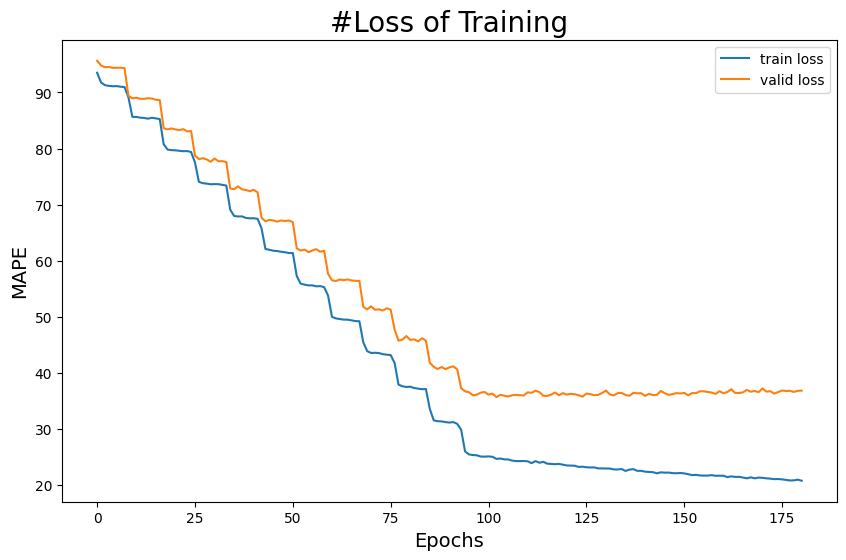

--------------------GCT------------------
### 2-The valid loss on loding model is 13.6306
#realy(valid) torch.Size([422, 49, 12])
# cat valid preds torch.Size([422, 49, 12])
valid vmae 13.25270938873291
#realy(test) torch.Size([843, 49, 12])
Evaluate best model on test data for horizon 1, Test MAE: 12.6354, Test MAPE: 0.1956, Test RMSE: 22.5720
Evaluate best model on test data for horizon 2, Test MAE: 13.1622, Test MAPE: 0.2034, Test RMSE: 23.6320
Evaluate best model on test data for horizon 3, Test MAE: 13.5441, Test MAPE: 0.2112, Test RMSE: 24.3290
Evaluate best model on test data for horizon 4, Test MAE: 13.8529, Test MAPE: 0.2156, Test RMSE: 25.0509
Evaluate best model on test data for horizon 5, Test MAE: 14.0459, Test MAPE: 0.2116, Test RMSE: 25.1947
Evaluate best model on test data for horizon 6, Test MAE: 14.2939, Test MAPE: 0.2135, Test RMSE: 25.4208
Evaluate best model on test data for horizon 7, Test MAE: 14.6285, Test MAPE: 0.2226, Test RMSE: 26.0090
Evaluate best model on 

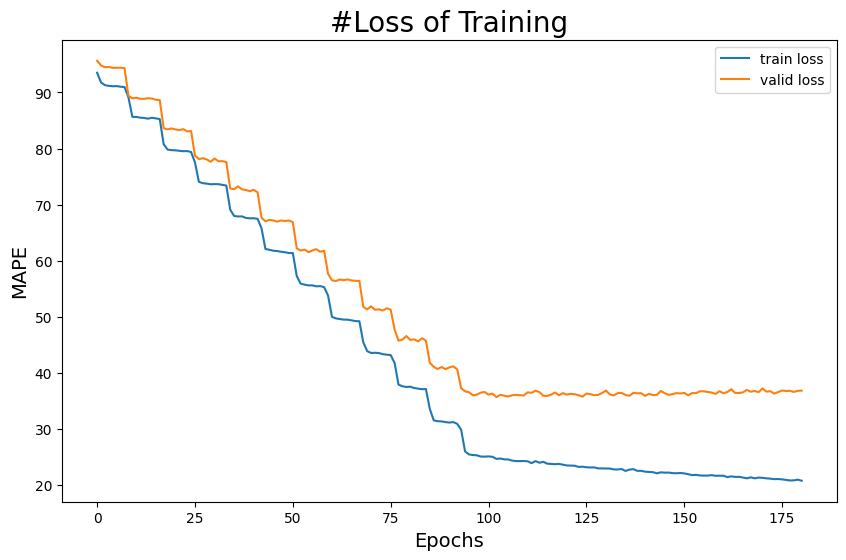

--------------------Fusion------------------
### loading model is: ./save/exp202401251640_0.pth ###
### Loading Model finished ###
### The valid loss on loding model is 39.7523
in fusion.................
### 2-The valid loss on loding model is 39.7523
### 2-The valid(unseen) loss on loding model is 151.3616
#realy(valid) torch.Size([422, 8, 12])
in fusion................. 2
# cat valid preds torch.Size([422, 8, 12])
valid vmae 38.40570831298828
#realy(test) torch.Size([843, 12, 9, 2])
#-------------------unseen--------------------#
Evaluate best model on test data for horizon 1, Test MAE: 156.3946, Test MAPE: 0.7068, Test RMSE: 167.8750
Evaluate best model on test data for horizon 2, Test MAE: 150.4399, Test MAPE: 0.6727, Test RMSE: 162.5249
Evaluate best model on test data for horizon 3, Test MAE: 149.3992, Test MAPE: 0.6675, Test RMSE: 161.3152


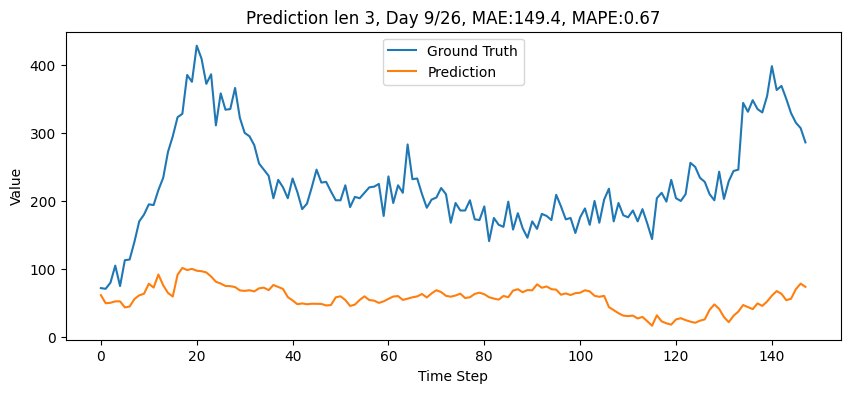

#real [ 72.  71.  80. 105.  75. 113. 114. 140. 170. 180. 195. 194. 216. 234.
 272. 295. 323. 328. 385. 375. 428. 409. 372. 386. 311. 358. 334. 335.
 366. 322. 300. 295. 282. 255. 246. 237. 204. 231. 220. 204. 233. 213.
 188. 196. 220. 246. 227. 228. 214. 201. 201. 223. 191. 206. 204. 212.
 220. 221. 225. 178. 236. 197. 223. 212. 283. 232. 233. 210. 190. 202.
 205. 219. 210. 168. 197. 186. 186. 201. 173. 172. 192. 141. 175. 165.
 162. 199. 158. 182. 160. 146. 170. 159. 181. 178. 172. 209. 192. 173.
 175. 153. 176. 189. 165. 200. 168. 202. 218. 170. 197. 179. 176. 186.
 170. 188. 167. 144. 204. 212. 199. 231. 204. 200. 210. 256. 250. 234.
 228. 210. 201. 243. 203. 229. 244. 246. 344. 331. 348. 335. 330. 354.
 398. 363. 369. 350. 329. 315. 307. 286.]
#predict [ 61.70806   49.767403  50.429314  52.55417   52.569817  43.65731
  44.96927   55.96034   61.419395  63.711597  78.377426  72.78608
  91.97273   76.220856  64.91412   59.68364   91.60348  101.61037
  98.56402  100.236824  97.554306  

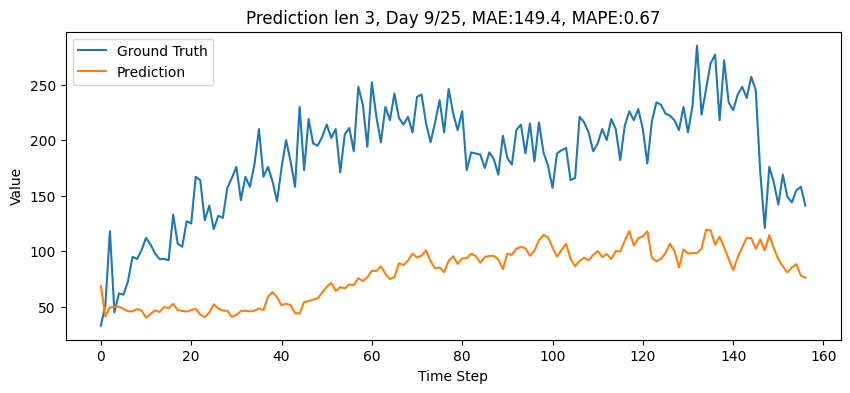

#real [ 33.  52. 118.  45.  62.  61.  73.  95.  93. 101. 112. 106.  98.  93.
  93.  92. 133. 107. 104. 127. 125. 167. 164. 128. 141. 120. 132. 130.
 157. 166. 176. 146. 167. 158. 178. 210. 167. 176. 163. 145. 175. 200.
 181. 158. 230. 173. 219. 197. 195. 203. 214. 202. 210. 171. 205. 211.
 190. 248. 232. 194. 252. 221. 198. 230. 218. 242. 220. 214. 221. 207.
 239. 241. 215. 198. 216. 236. 207. 246. 224. 209. 226. 173. 189. 188.
 187. 175. 189. 183. 169. 204. 184. 178. 209. 214. 188. 215. 181. 216.
 189. 177. 157. 188. 191. 193. 164. 166. 221. 216. 207. 190. 197. 210.
 200. 219. 210. 182. 213. 226. 218. 228. 210. 179. 217. 234. 232. 224.
 222. 218. 209. 230. 207. 231. 285. 223. 246. 269. 277. 218. 272. 234.
 227. 241. 248. 238. 257. 245. 171. 121. 176. 162. 142. 169. 149. 144.
 155. 158. 141.]
#predict [ 68.69065   41.254593  49.524357  50.197334  50.19023   48.160984
  46.01652   45.947952  47.92177   46.64361   40.313694  43.460793
  46.83825   45.355778  49.86845   48.79506   52.6249

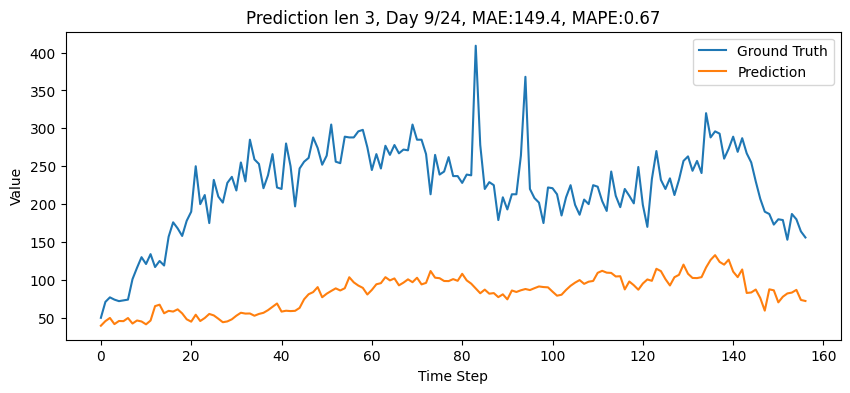

#real [ 50.  71.  77.  74.  72.  73.  74. 101. 116. 130. 121. 134. 117. 125.
 119. 157. 176. 168. 158. 178. 190. 250. 200. 212. 175. 232. 210. 202.
 228. 236. 218. 255. 230. 285. 259. 253. 221. 238. 266. 222. 220. 280.
 250. 197. 247. 256. 261. 288. 274. 252. 264. 305. 256. 254. 289. 288.
 288. 296. 298. 275. 245. 266. 247. 277. 265. 278. 267. 272. 271. 305.
 285. 285. 266. 213. 265. 239. 243. 262. 237. 237. 228. 239. 238. 409.
 278. 220. 229. 225. 179. 209. 193. 213. 213. 264. 368. 220. 208. 202.
 175. 222. 221. 213. 185. 209. 225. 199. 186. 206. 200. 225. 223. 204.
 191. 243. 211. 196. 220. 211. 201. 249. 199. 170. 233. 270. 232. 220.
 234. 212. 232. 257. 263. 244. 257. 241. 320. 288. 296. 293. 260. 273.
 289. 269. 287. 267. 255. 230. 207. 190. 187. 173. 180. 179. 153. 187.
 180. 164. 156.]
#predict [ 39.567047  45.642708  49.82735   41.695934  45.80986   45.607384
  49.717438  42.452152  46.472775  45.172855  41.395916  46.39037
  65.413536  67.32979   55.977203  59.211098  58.25325

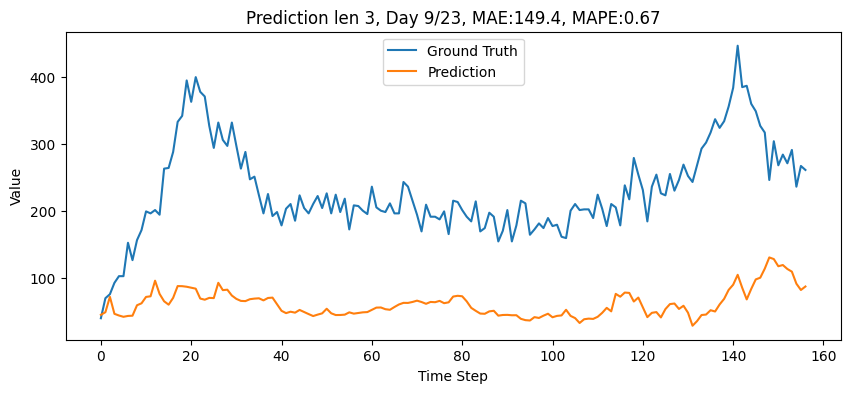

#real [ 39.  69.  75.  92. 102. 102. 152. 126. 156. 171. 199. 196. 201. 194.
 263. 264. 288. 333. 342. 395. 363. 400. 378. 371. 327. 294. 332. 306.
 297. 332. 297. 263. 288. 247. 251. 223. 196. 225. 192. 198. 178. 203.
 210. 185. 223. 204. 196. 210. 222. 204. 226. 196. 224. 198. 218. 172.
 208. 207. 200. 195. 236. 205. 200. 198. 211. 196. 196. 243. 236. 215.
 194. 169. 209. 191. 191. 187. 199. 165. 215. 213. 201. 191. 184. 214.
 169. 174. 197. 191. 154. 170. 201. 154. 178. 215. 211. 164. 172. 181.
 174. 189. 177. 179. 161. 159. 200. 210. 201. 202. 202. 189. 224. 203.
 177. 210. 205. 178. 238. 217. 279. 254. 231. 184. 236. 254. 226. 223.
 255. 230. 246. 269. 252. 243. 268. 293. 302. 317. 337. 324. 334. 356.
 384. 447. 385. 387. 360. 349. 327. 317. 246. 304. 268. 284. 271. 291.
 236. 267. 261.]
#predict [ 44.11172   48.04864   71.05411   45.625748  43.119392  41.164787
  42.46356   42.82602   58.455948  61.38292   70.92688   71.85801
  95.198524  75.39896   64.41566   59.335045  69.57451

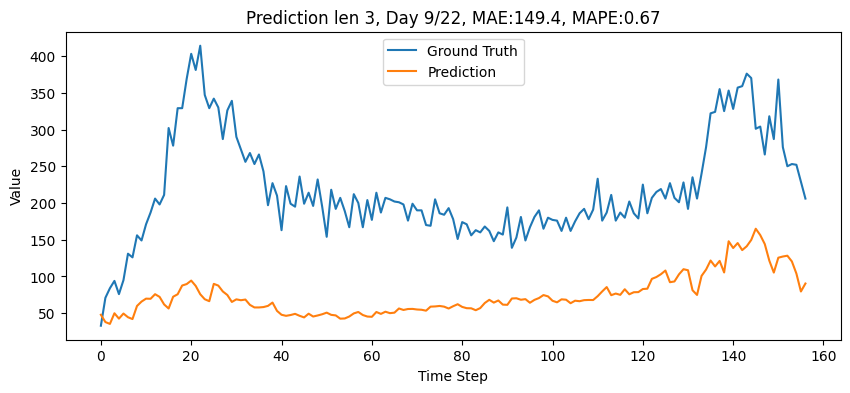

#real [ 33.  71.  84.  94.  76.  95. 131. 126. 156. 149. 171. 187. 206. 198.
 211. 302. 278. 329. 329. 369. 403. 381. 414. 347. 329. 342. 330. 287.
 326. 339. 290. 273. 256. 268. 253. 266. 243. 197. 227. 210. 163. 223.
 199. 195. 236. 199. 214. 196. 232. 195. 154. 218. 192. 207. 189. 167.
 212. 200. 167. 204. 177. 214. 187. 207. 205. 202. 201. 198. 176. 199.
 190. 190. 170. 169. 205. 186. 184. 193. 178. 151. 174. 171. 156. 163.
 160. 168. 162. 148. 160. 157. 194. 139. 153. 181. 149. 167. 181. 190.
 165. 180. 177. 176. 162. 180. 162. 175. 186. 192. 178. 191. 233. 176.
 187. 211. 176. 187. 180. 202. 186. 179. 225. 186. 207. 215. 219. 206.
 227. 207. 201. 228. 192. 235. 206. 240. 276. 322. 324. 355. 325. 353.
 328. 357. 359. 376. 370. 301. 304. 266. 318. 287. 368. 276. 250. 253.
 252. 229. 206.]
#predict [ 47.915077  37.970196  35.484486  49.94869   42.64821   49.56938
  44.557594  42.0621    59.88082   65.84732   69.84662   69.64905
  75.896774  72.234985  61.989914  56.435543  72.44749 

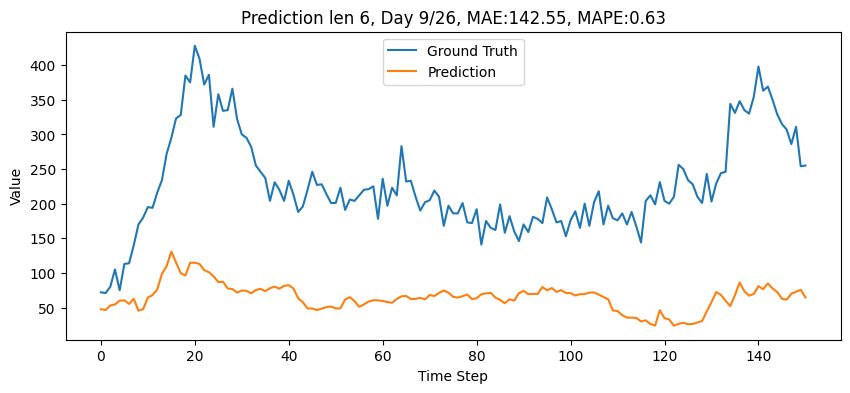

#real [ 72.  71.  80. 105.  75. 113. 114. 140. 170. 180. 195. 194. 216. 234.
 272. 295. 323. 328. 385. 375. 428. 409. 372. 386. 311. 358. 334. 335.
 366. 322. 300. 295. 282. 255. 246. 237. 204. 231. 220. 204. 233. 213.
 188. 196. 220. 246. 227. 228. 214. 201. 201. 223. 191. 206. 204. 212.
 220. 221. 225. 178. 236. 197. 223. 212. 283. 232. 233. 210. 190. 202.
 205. 219. 210. 168. 197. 186. 186. 201. 173. 172. 192. 141. 175. 165.
 162. 199. 158. 182. 160. 146. 170. 159. 181. 178. 172. 209. 192. 173.
 175. 153. 176. 189. 165. 200. 168. 202. 218. 170. 197. 179. 176. 186.
 170. 188. 167. 144. 204. 212. 199. 231. 204. 200. 210. 256. 250. 234.
 228. 210. 201. 243. 203. 229. 244. 246. 344. 331. 348. 335. 330. 354.
 398. 363. 369. 350. 329. 315. 307. 286. 311. 254. 255.]
#predict [ 47.65045   46.471657  53.051315  54.56839   60.067265  60.3684
  55.32277   62.69185   45.536385  47.836056  64.56028   68.04875
  76.27066   98.64774  109.88352  130.93079  115.10719   99.57032
  96.347916 114.64549

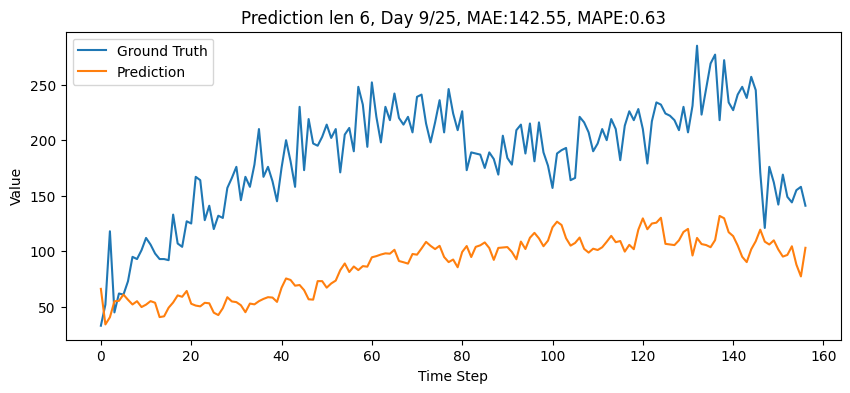

#real [ 33.  52. 118.  45.  62.  61.  73.  95.  93. 101. 112. 106.  98.  93.
  93.  92. 133. 107. 104. 127. 125. 167. 164. 128. 141. 120. 132. 130.
 157. 166. 176. 146. 167. 158. 178. 210. 167. 176. 163. 145. 175. 200.
 181. 158. 230. 173. 219. 197. 195. 203. 214. 202. 210. 171. 205. 211.
 190. 248. 232. 194. 252. 221. 198. 230. 218. 242. 220. 214. 221. 207.
 239. 241. 215. 198. 216. 236. 207. 246. 224. 209. 226. 173. 189. 188.
 187. 175. 189. 183. 169. 204. 184. 178. 209. 214. 188. 215. 181. 216.
 189. 177. 157. 188. 191. 193. 164. 166. 221. 216. 207. 190. 197. 210.
 200. 219. 210. 182. 213. 226. 218. 228. 210. 179. 217. 234. 232. 224.
 222. 218. 209. 230. 207. 231. 285. 223. 246. 269. 277. 218. 272. 234.
 227. 241. 248. 238. 257. 245. 171. 121. 176. 162. 142. 169. 149. 144.
 155. 158. 141.]
#predict [ 66.16966   34.155315  40.620983  54.996605  55.38405   61.04457
  56.37063   52.1258    55.071396  49.80487   51.96971   55.1301
  53.681442  40.755558  41.466923  49.213715  53.922714 

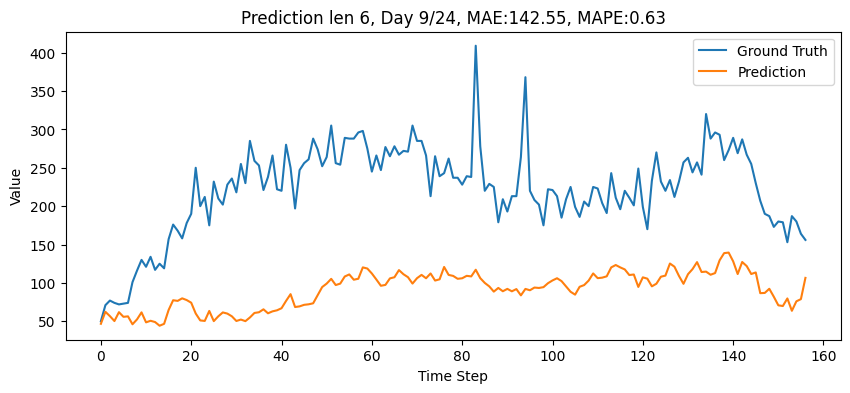

#real [ 50.  71.  77.  74.  72.  73.  74. 101. 116. 130. 121. 134. 117. 125.
 119. 157. 176. 168. 158. 178. 190. 250. 200. 212. 175. 232. 210. 202.
 228. 236. 218. 255. 230. 285. 259. 253. 221. 238. 266. 222. 220. 280.
 250. 197. 247. 256. 261. 288. 274. 252. 264. 305. 256. 254. 289. 288.
 288. 296. 298. 275. 245. 266. 247. 277. 265. 278. 267. 272. 271. 305.
 285. 285. 266. 213. 265. 239. 243. 262. 237. 237. 228. 239. 238. 409.
 278. 220. 229. 225. 179. 209. 193. 213. 213. 264. 368. 220. 208. 202.
 175. 222. 221. 213. 185. 209. 225. 199. 186. 206. 200. 225. 223. 204.
 191. 243. 211. 196. 220. 211. 201. 249. 199. 170. 233. 270. 232. 220.
 234. 212. 232. 257. 263. 244. 257. 241. 320. 288. 296. 293. 260. 273.
 289. 269. 287. 267. 255. 230. 207. 190. 187. 173. 180. 179. 153. 187.
 180. 164. 156.]
#predict [ 46.731266  62.370094  56.713028  50.30137   61.85377   55.813644
  56.43695   46.12098   52.451622  61.628014  48.641262  50.671356
  49.014584  44.2277    46.68217   64.75581   77.4282

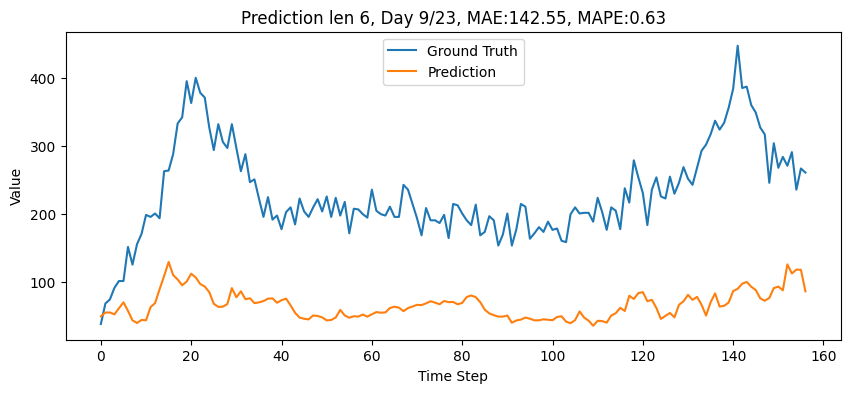

#real [ 39.  69.  75.  92. 102. 102. 152. 126. 156. 171. 199. 196. 201. 194.
 263. 264. 288. 333. 342. 395. 363. 400. 378. 371. 327. 294. 332. 306.
 297. 332. 297. 263. 288. 247. 251. 223. 196. 225. 192. 198. 178. 203.
 210. 185. 223. 204. 196. 210. 222. 204. 226. 196. 224. 198. 218. 172.
 208. 207. 200. 195. 236. 205. 200. 198. 211. 196. 196. 243. 236. 215.
 194. 169. 209. 191. 191. 187. 199. 165. 215. 213. 201. 191. 184. 214.
 169. 174. 197. 191. 154. 170. 201. 154. 178. 215. 211. 164. 172. 181.
 174. 189. 177. 179. 161. 159. 200. 210. 201. 202. 202. 189. 224. 203.
 177. 210. 205. 178. 238. 217. 279. 254. 231. 184. 236. 254. 226. 223.
 255. 230. 246. 269. 252. 243. 268. 293. 302. 317. 337. 324. 334. 356.
 384. 447. 385. 387. 360. 349. 327. 317. 246. 304. 268. 284. 271. 291.
 236. 267. 261.]
#predict [ 50.27422   55.79574   55.84194   53.142803  62.114277  70.69959
  58.25595   44.289207  40.477997  44.92852   44.433243  63.69345
  69.64518   89.94551  109.27749  129.93417  110.73606 

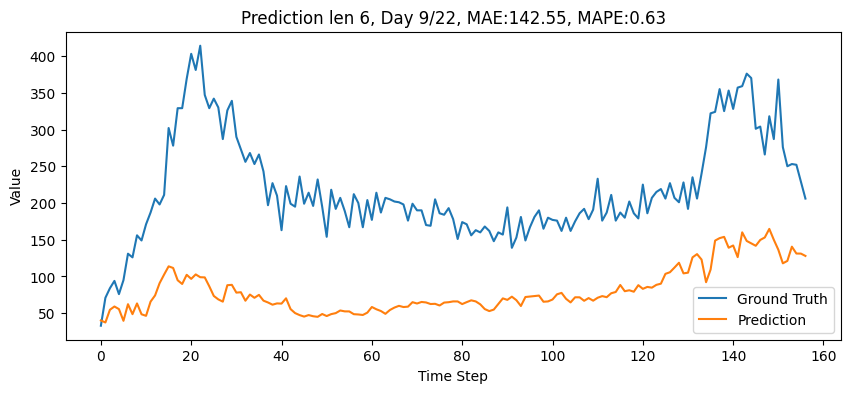

#real [ 33.  71.  84.  94.  76.  95. 131. 126. 156. 149. 171. 187. 206. 198.
 211. 302. 278. 329. 329. 369. 403. 381. 414. 347. 329. 342. 330. 287.
 326. 339. 290. 273. 256. 268. 253. 266. 243. 197. 227. 210. 163. 223.
 199. 195. 236. 199. 214. 196. 232. 195. 154. 218. 192. 207. 189. 167.
 212. 200. 167. 204. 177. 214. 187. 207. 205. 202. 201. 198. 176. 199.
 190. 190. 170. 169. 205. 186. 184. 193. 178. 151. 174. 171. 156. 163.
 160. 168. 162. 148. 160. 157. 194. 139. 153. 181. 149. 167. 181. 190.
 165. 180. 177. 176. 162. 180. 162. 175. 186. 192. 178. 191. 233. 176.
 187. 211. 176. 187. 180. 202. 186. 179. 225. 186. 207. 215. 219. 206.
 227. 207. 201. 228. 192. 235. 206. 240. 276. 322. 324. 355. 325. 353.
 328. 357. 359. 376. 370. 301. 304. 266. 318. 287. 368. 276. 250. 253.
 252. 229. 206.]
#predict [ 40.202087  37.415028  54.68917   59.162003  55.597504  39.684544
  62.290466  48.723644  63.323204  48.567867  46.47451   65.752556
  74.23742   90.88183  102.609634 113.80079  111.5795

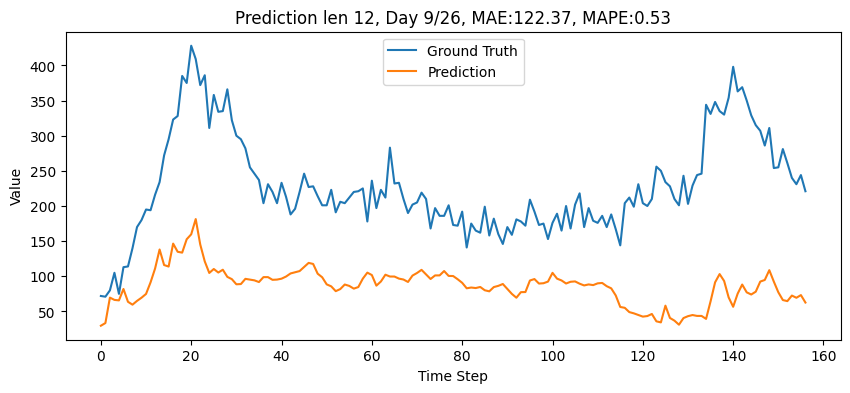

#real [ 72.  71.  80. 105.  75. 113. 114. 140. 170. 180. 195. 194. 216. 234.
 272. 295. 323. 328. 385. 375. 428. 409. 372. 386. 311. 358. 334. 335.
 366. 322. 300. 295. 282. 255. 246. 237. 204. 231. 220. 204. 233. 213.
 188. 196. 220. 246. 227. 228. 214. 201. 201. 223. 191. 206. 204. 212.
 220. 221. 225. 178. 236. 197. 223. 212. 283. 232. 233. 210. 190. 202.
 205. 219. 210. 168. 197. 186. 186. 201. 173. 172. 192. 141. 175. 165.
 162. 199. 158. 182. 160. 146. 170. 159. 181. 178. 172. 209. 192. 173.
 175. 153. 176. 189. 165. 200. 168. 202. 218. 170. 197. 179. 176. 186.
 170. 188. 167. 144. 204. 212. 199. 231. 204. 200. 210. 256. 250. 234.
 228. 210. 201. 243. 203. 229. 244. 246. 344. 331. 348. 335. 330. 354.
 398. 363. 369. 350. 329. 315. 307. 286. 311. 254. 255. 281. 261. 240.
 231. 244. 221.]
#predict [ 29.697605  33.496567  69.686005  66.43531   65.73177   81.952156
  63.73143   59.642456  65.000114  69.54543   74.92563   91.40992
 111.0489   138.11958  116.01851  113.853485 146.49847

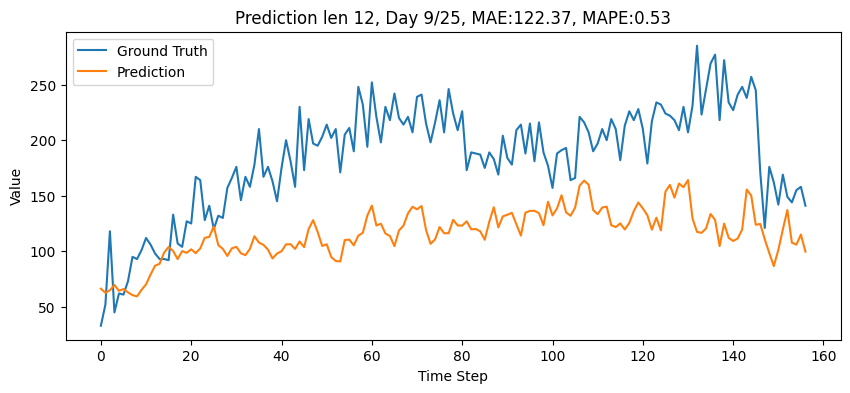

#real [ 33.  52. 118.  45.  62.  61.  73.  95.  93. 101. 112. 106.  98.  93.
  93.  92. 133. 107. 104. 127. 125. 167. 164. 128. 141. 120. 132. 130.
 157. 166. 176. 146. 167. 158. 178. 210. 167. 176. 163. 145. 175. 200.
 181. 158. 230. 173. 219. 197. 195. 203. 214. 202. 210. 171. 205. 211.
 190. 248. 232. 194. 252. 221. 198. 230. 218. 242. 220. 214. 221. 207.
 239. 241. 215. 198. 216. 236. 207. 246. 224. 209. 226. 173. 189. 188.
 187. 175. 189. 183. 169. 204. 184. 178. 209. 214. 188. 215. 181. 216.
 189. 177. 157. 188. 191. 193. 164. 166. 221. 216. 207. 190. 197. 210.
 200. 219. 210. 182. 213. 226. 218. 228. 210. 179. 217. 234. 232. 224.
 222. 218. 209. 230. 207. 231. 285. 223. 246. 269. 277. 218. 272. 234.
 227. 241. 248. 238. 257. 245. 171. 121. 176. 162. 142. 169. 149. 144.
 155. 158. 141.]
#predict [ 66.326004  62.610146  64.86118   69.70388   64.39042   66.0378
  63.025696  60.567482  59.38231   65.2553    70.25961   79.03068
  87.02188   88.72393   98.758545 103.887695 100.26304  

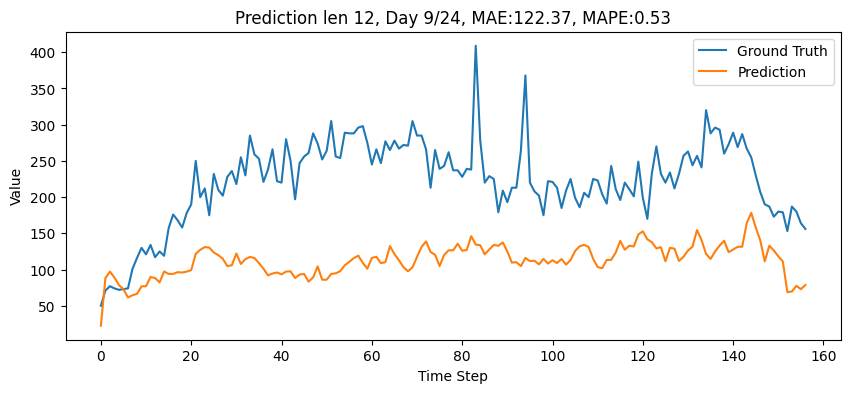

#real [ 50.  71.  77.  74.  72.  73.  74. 101. 116. 130. 121. 134. 117. 125.
 119. 157. 176. 168. 158. 178. 190. 250. 200. 212. 175. 232. 210. 202.
 228. 236. 218. 255. 230. 285. 259. 253. 221. 238. 266. 222. 220. 280.
 250. 197. 247. 256. 261. 288. 274. 252. 264. 305. 256. 254. 289. 288.
 288. 296. 298. 275. 245. 266. 247. 277. 265. 278. 267. 272. 271. 305.
 285. 285. 266. 213. 265. 239. 243. 262. 237. 237. 228. 239. 238. 409.
 278. 220. 229. 225. 179. 209. 193. 213. 213. 264. 368. 220. 208. 202.
 175. 222. 221. 213. 185. 209. 225. 199. 186. 206. 200. 225. 223. 204.
 191. 243. 211. 196. 220. 211. 201. 249. 199. 170. 233. 270. 232. 220.
 234. 212. 232. 257. 263. 244. 257. 241. 320. 288. 296. 293. 260. 273.
 289. 269. 287. 267. 255. 230. 207. 190. 187. 173. 180. 179. 153. 187.
 180. 164. 156.]
#predict [ 22.460445  88.18254   97.142204  89.01619   78.632675  72.80371
  61.52716   64.51107   66.454025  76.78049   77.06345   89.84386
  88.2546    82.28428   97.36619   93.998764  94.0106  

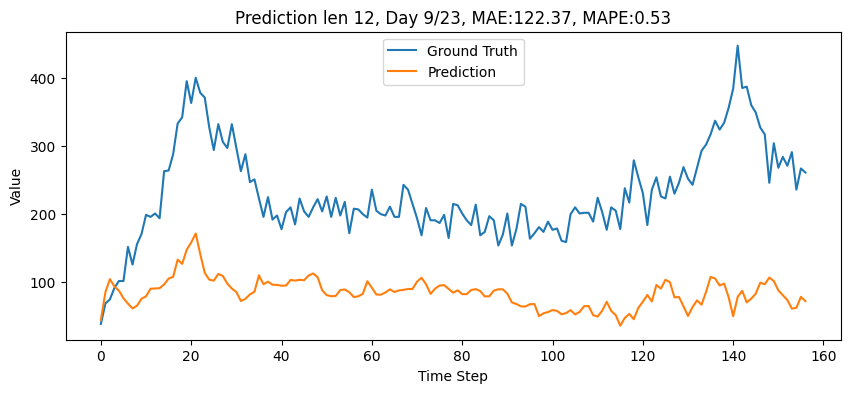

#real [ 39.  69.  75.  92. 102. 102. 152. 126. 156. 171. 199. 196. 201. 194.
 263. 264. 288. 333. 342. 395. 363. 400. 378. 371. 327. 294. 332. 306.
 297. 332. 297. 263. 288. 247. 251. 223. 196. 225. 192. 198. 178. 203.
 210. 185. 223. 204. 196. 210. 222. 204. 226. 196. 224. 198. 218. 172.
 208. 207. 200. 195. 236. 205. 200. 198. 211. 196. 196. 243. 236. 215.
 194. 169. 209. 191. 191. 187. 199. 165. 215. 213. 201. 191. 184. 214.
 169. 174. 197. 191. 154. 170. 201. 154. 178. 215. 211. 164. 172. 181.
 174. 189. 177. 179. 161. 159. 200. 210. 201. 202. 202. 189. 224. 203.
 177. 210. 205. 178. 238. 217. 279. 254. 231. 184. 236. 254. 226. 223.
 255. 230. 246. 269. 252. 243. 268. 293. 302. 317. 337. 324. 334. 356.
 384. 447. 385. 387. 360. 349. 327. 317. 246. 304. 268. 284. 271. 291.
 236. 267. 261.]
#predict [ 44.89084   85.46561  104.68156   93.920746  87.82011   76.63003
  68.785866  61.756645  65.72019   75.98835   79.50757   90.61839
  91.10025   91.42657   96.86372  105.64269  108.16104 

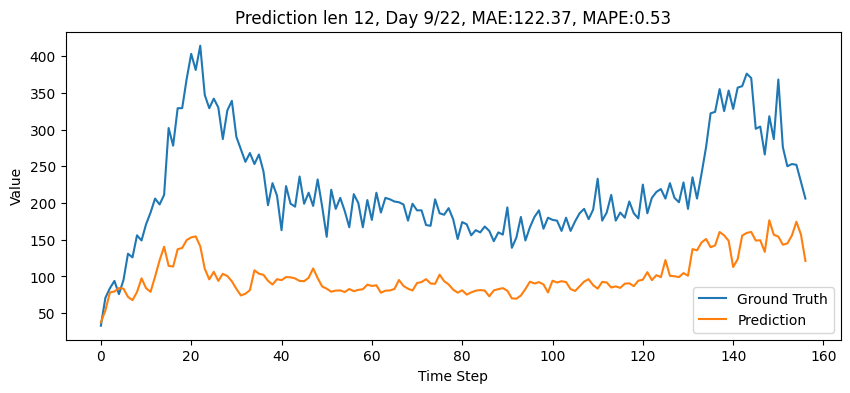

#real [ 33.  71.  84.  94.  76.  95. 131. 126. 156. 149. 171. 187. 206. 198.
 211. 302. 278. 329. 329. 369. 403. 381. 414. 347. 329. 342. 330. 287.
 326. 339. 290. 273. 256. 268. 253. 266. 243. 197. 227. 210. 163. 223.
 199. 195. 236. 199. 214. 196. 232. 195. 154. 218. 192. 207. 189. 167.
 212. 200. 167. 204. 177. 214. 187. 207. 205. 202. 201. 198. 176. 199.
 190. 190. 170. 169. 205. 186. 184. 193. 178. 151. 174. 171. 156. 163.
 160. 168. 162. 148. 160. 157. 194. 139. 153. 181. 149. 167. 181. 190.
 165. 180. 177. 176. 162. 180. 162. 175. 186. 192. 178. 191. 233. 176.
 187. 211. 176. 187. 180. 202. 186. 179. 225. 186. 207. 215. 219. 206.
 227. 207. 201. 228. 192. 235. 206. 240. 276. 322. 324. 355. 325. 353.
 328. 357. 359. 376. 370. 301. 304. 266. 318. 287. 368. 276. 250. 253.
 252. 229. 206.]
#predict [ 37.65347   53.84922   78.34195   79.588684  84.1777    83.42222
  72.26257   67.74263   78.87487   97.51727   84.09657   79.11377
  99.77853  121.96126  140.51999  114.47749  113.46551 

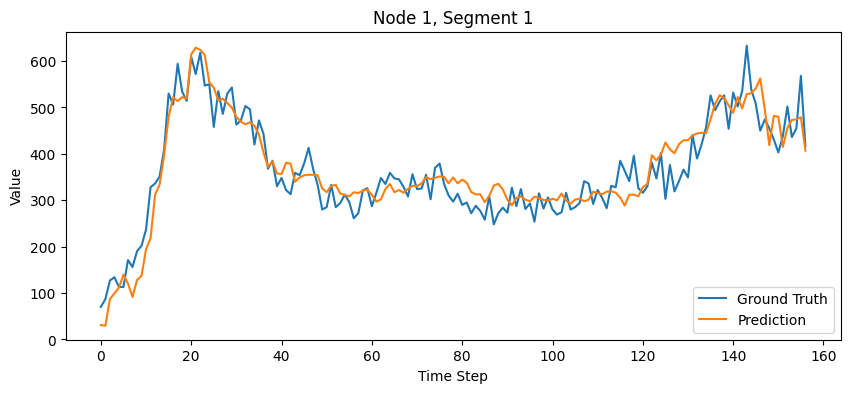

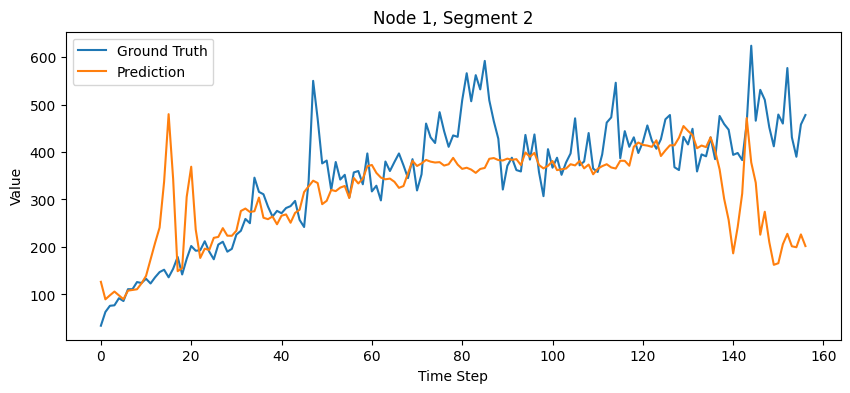

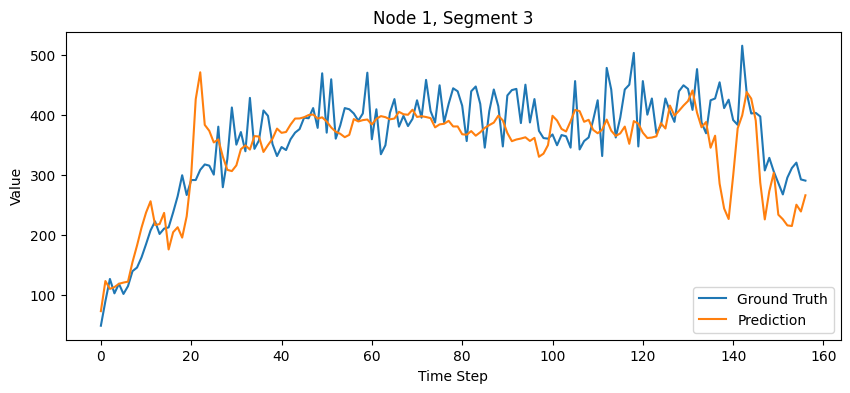

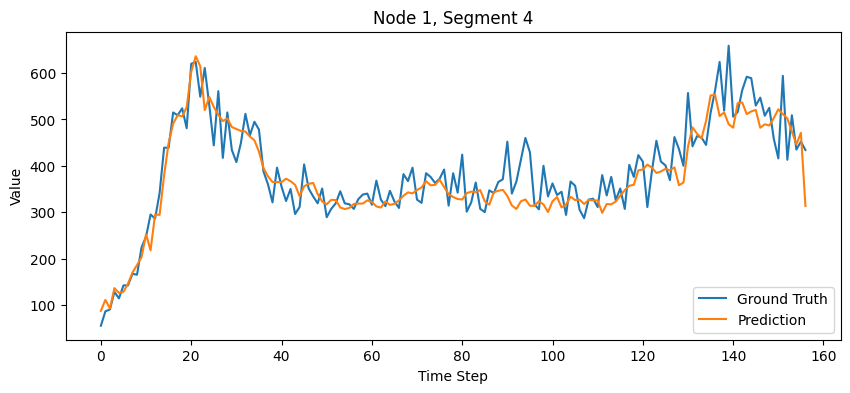

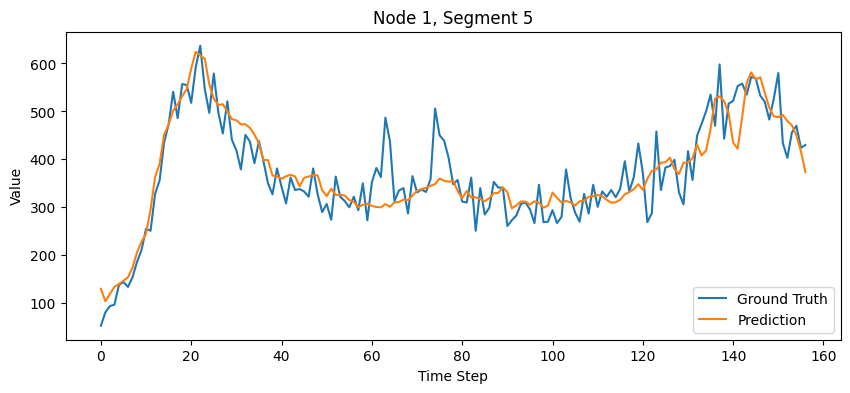

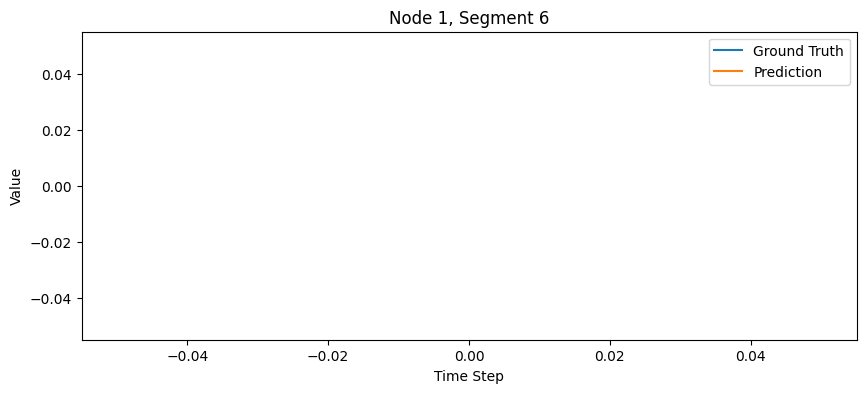

last gt_segment tensor([ 44.,  81.,  68.,  86.,  87.,  80., 152., 104., 135., 159., 178., 196.,
        204., 363., 347., 440., 424., 462., 467., 488., 535., 466., 340., 364.,
        331., 305., 338., 367., 337., 308., 342., 361., 281., 290., 292., 295.,
        288., 287., 222., 301., 289., 260., 295., 257., 309., 274., 272., 306.,
        276., 278., 290., 254., 266., 294., 284., 302., 293., 356., 289., 296.,
        317., 311., 297., 330., 348., 298., 316., 285., 318., 329., 276., 326.,
        380., 300., 286., 338., 252., 255., 237., 253., 265., 230., 265., 255.,
        270., 202., 229., 220., 208., 232., 233., 272., 239., 244., 264., 252.,
        261., 242., 232., 252., 245., 300., 278., 290., 259., 262., 268., 256.,
        294., 270., 277., 237., 265., 269., 275., 296., 309., 333., 319., 258.,
        371., 367., 320., 313., 343., 338., 322., 291., 365., 417., 368., 418.,
        438., 398., 396., 445., 473., 466., 440., 478., 416., 379., 358., 396.,
        383., 352., 229.

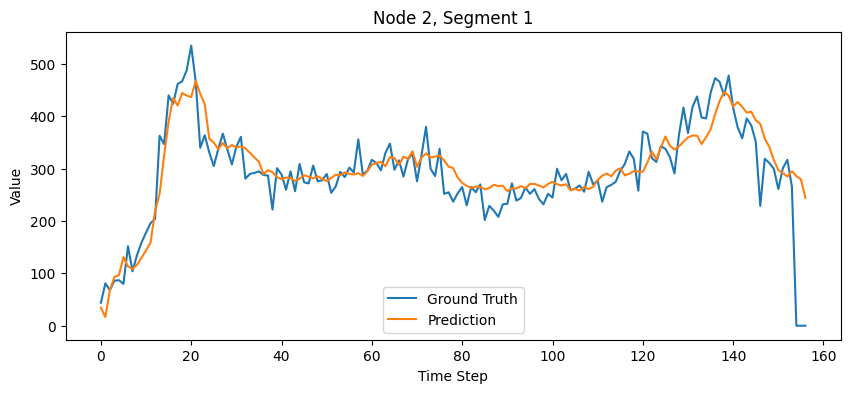

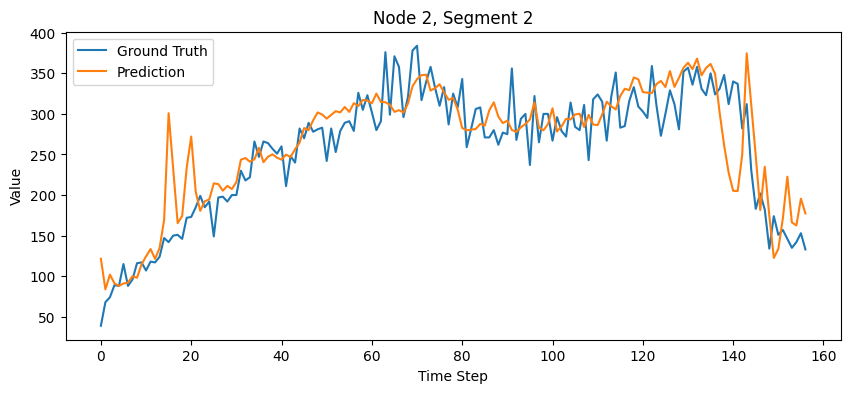

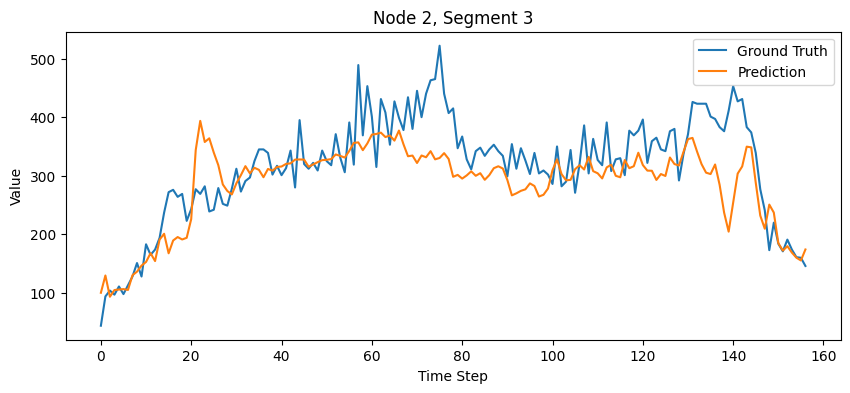

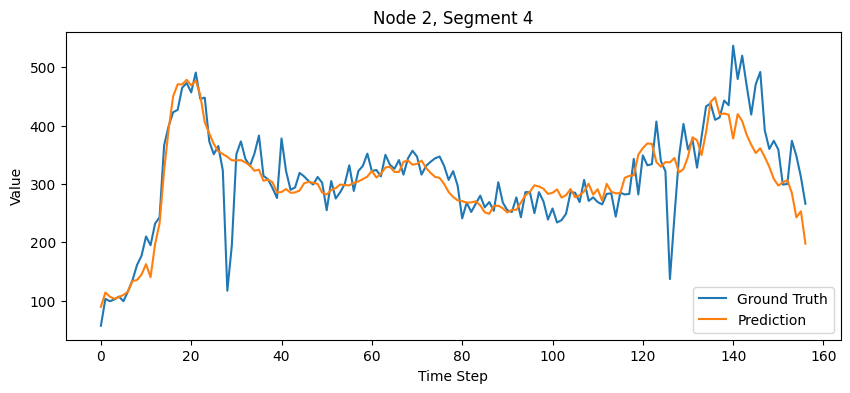

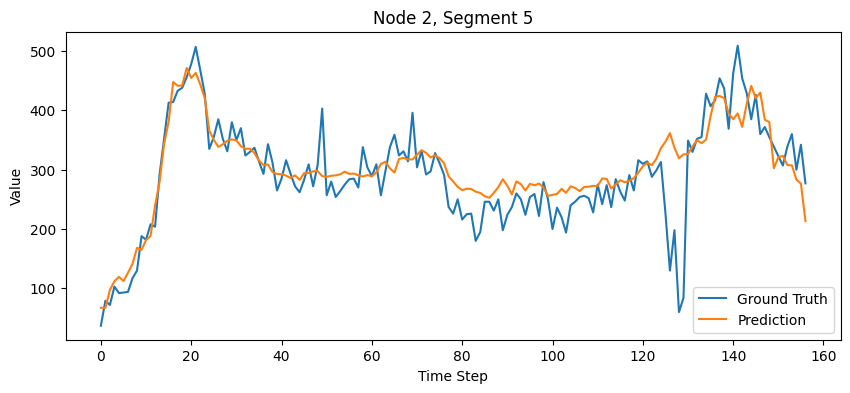

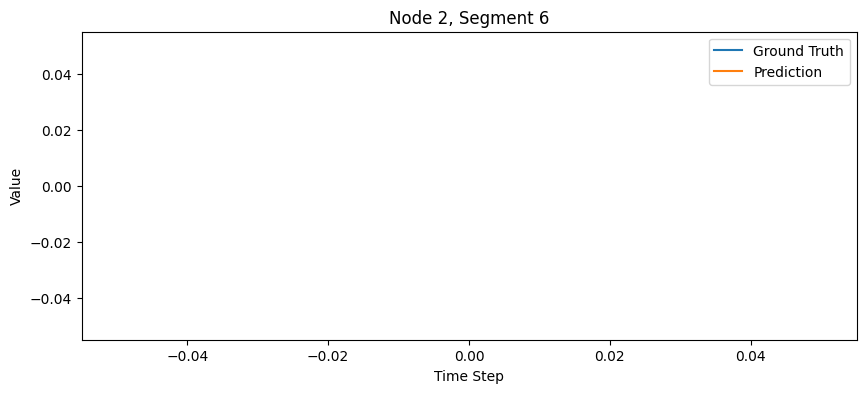

last gt_segment tensor([ 83.,  70.,  94., 138., 153., 159., 200., 218., 248., 260., 318., 371.,
        307., 452., 472., 478., 550., 523., 674., 794., 767., 844., 762., 815.,
        707., 764., 775., 715., 674., 588., 512., 555., 472., 558., 457., 469.,
        321., 311., 272., 299., 292., 261., 275., 249., 226., 294., 240., 229.,
        213., 201., 183., 186., 185., 158., 163., 160., 175., 170., 150., 187.,
        147., 171., 183., 216., 201., 167., 209., 214., 220., 239., 201., 213.,
        231., 237., 272., 249., 229., 191., 206., 193., 211., 217., 189., 198.,
        175., 198., 173., 189., 141., 181., 122., 140., 148., 133., 121., 149.,
        158., 159., 155., 167., 151., 135., 132., 117., 116., 127., 115., 146.,
        146., 131., 168., 151., 169., 142., 182., 173., 189., 205., 170., 179.,
        177., 190., 222., 188., 212., 163., 159., 176., 200., 241., 230., 234.,
        234., 312., 435., 577., 553., 470., 473., 505., 699., 677., 702., 521.,
        607., 526., 547.

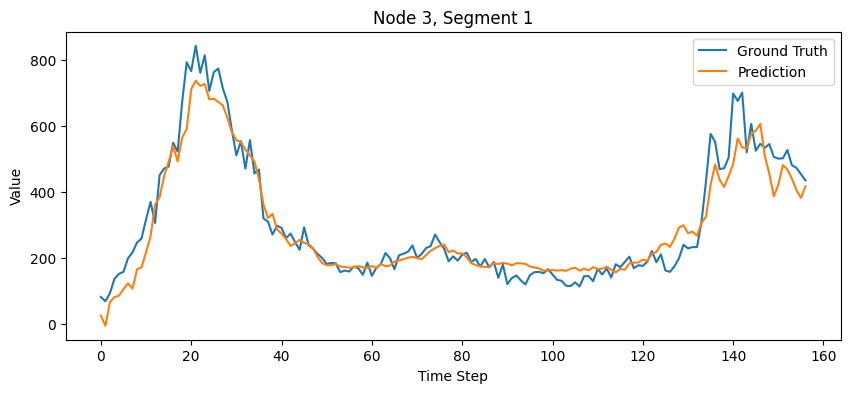

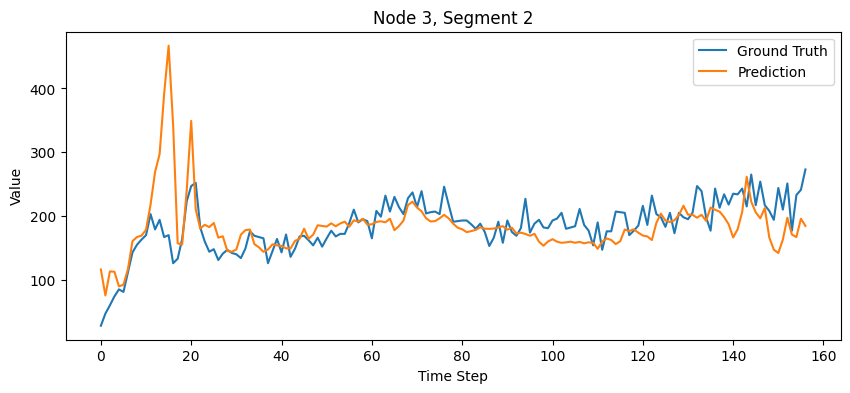

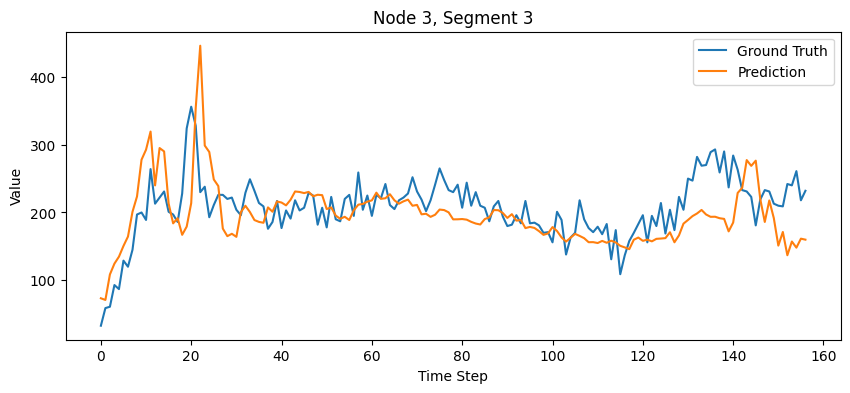

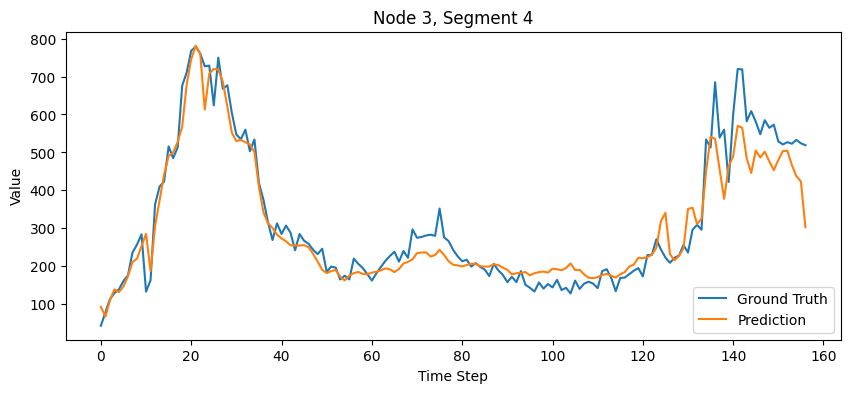

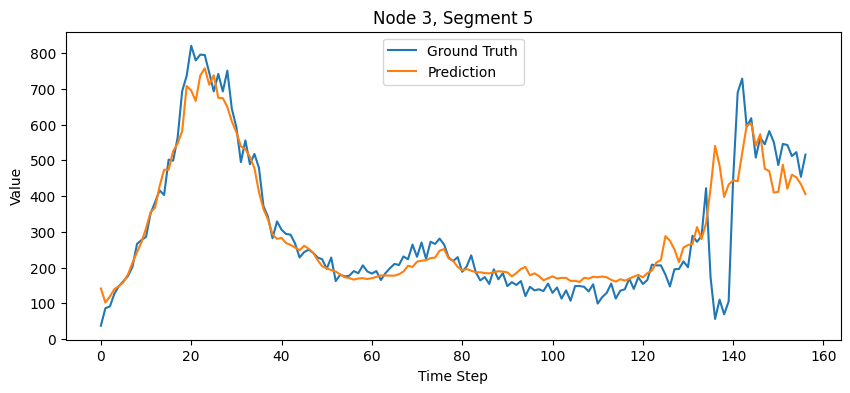

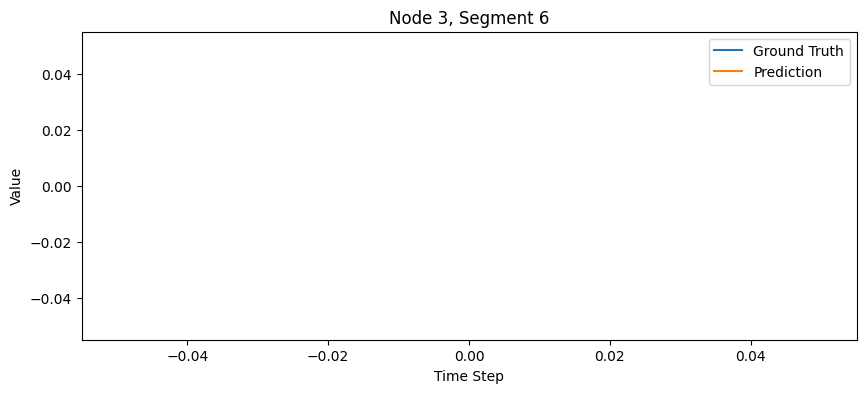

last gt_segment tensor([ 82.,  66., 107., 147., 158., 157., 230., 222., 270., 261., 340., 357.,
        422., 414., 268., 390., 348., 318., 675., 774., 784., 803., 838., 809.,
        783., 736., 741., 734., 662., 591., 494., 521., 553., 490., 505., 371.,
        349., 294., 271., 282., 299., 286., 261., 230., 274., 249., 234., 236.,
        215., 193., 167., 169., 172., 161., 173., 140., 182., 151., 173., 164.,
        138., 179., 175., 210., 192., 174., 188., 216., 215., 222., 212., 207.,
        206., 207., 272., 234., 241., 197., 221., 168., 223., 197., 212., 193.,
        169., 194., 193., 182., 185., 199., 183., 156., 175., 170., 148., 155.,
        188., 142., 172., 159., 167., 139., 172., 151., 161., 152., 169., 168.,
        150., 156., 188., 189., 199., 139., 187., 156., 205., 185., 192., 179.,
        220., 201., 264., 248., 243., 227., 207., 193., 238., 230., 247., 263.,
        217., 267., 436., 536., 530., 484., 430., 496., 528., 673., 525., 488.,
        493., 346., 415.

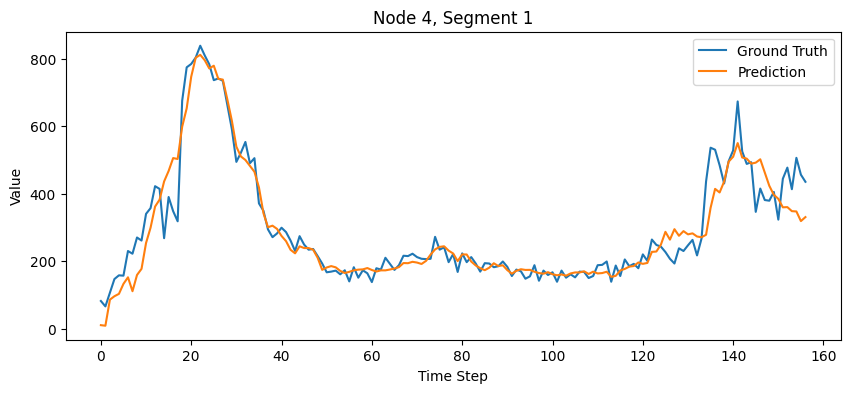

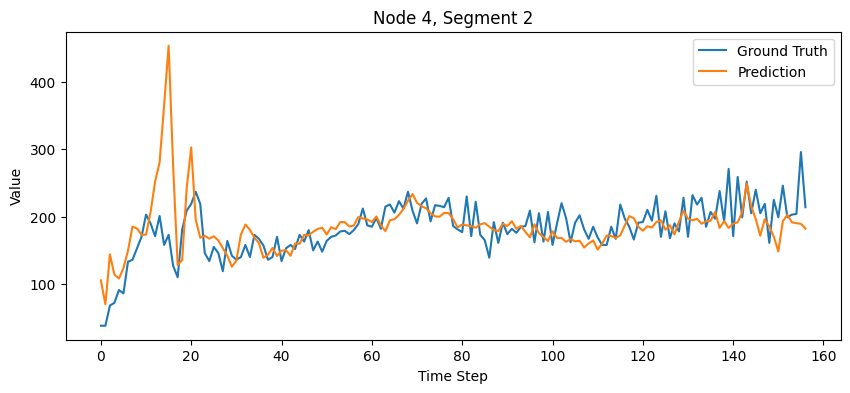

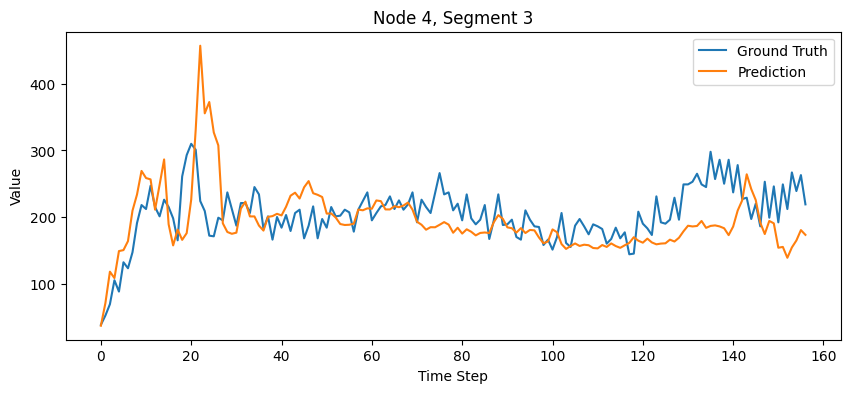

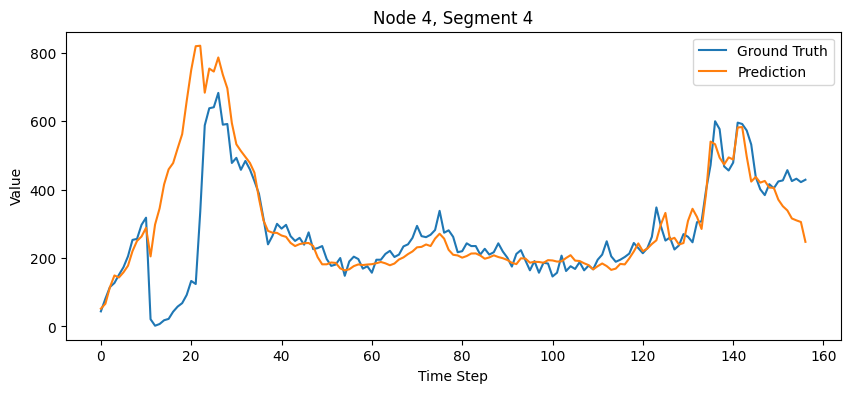

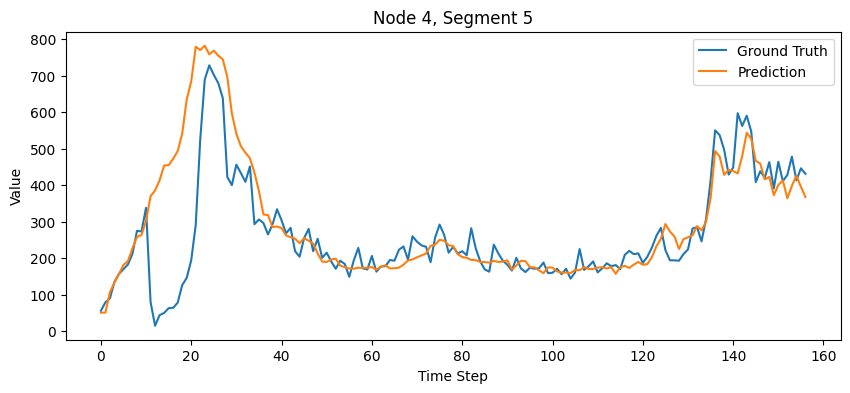

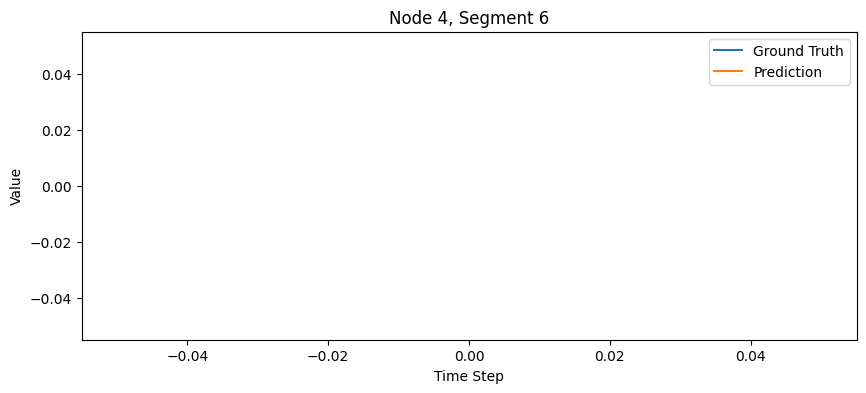

last gt_segment tensor([ 32.,  41.,  48.,  57.,  60.,  77.,  76., 101., 133., 139., 179., 195.,
        237., 178., 297., 292., 315., 323., 401., 336., 486., 398., 505., 381.,
        379., 397., 436., 360., 401., 363., 382., 355., 359., 387., 379., 320.,
        267., 259., 255., 192., 271., 192., 196., 170., 204., 177., 171., 172.,
        138., 143., 155., 156., 155., 169., 163., 158., 172., 193., 173., 154.,
        191., 158., 134., 163., 185., 171., 160., 142., 168., 173., 166., 168.,
        155., 175., 171., 153., 174., 151., 137., 131., 129., 114., 138., 157.,
        154., 117., 150., 141., 125., 151., 127., 153., 153., 136., 135., 144.,
        169., 147., 140., 178., 128., 120., 169., 152., 140., 144., 152., 133.,
        151., 127., 166., 145., 182., 149., 136., 163., 164., 165., 169., 172.,
        144., 165., 189., 187., 175., 197., 182., 175., 206., 210., 202., 228.,
        208., 214., 227., 279., 252., 274., 239., 227., 281., 293., 285., 318.,
        290., 229., 281.

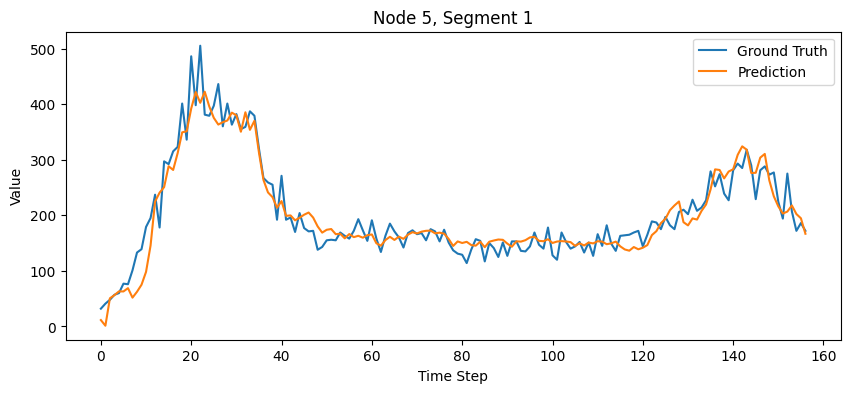

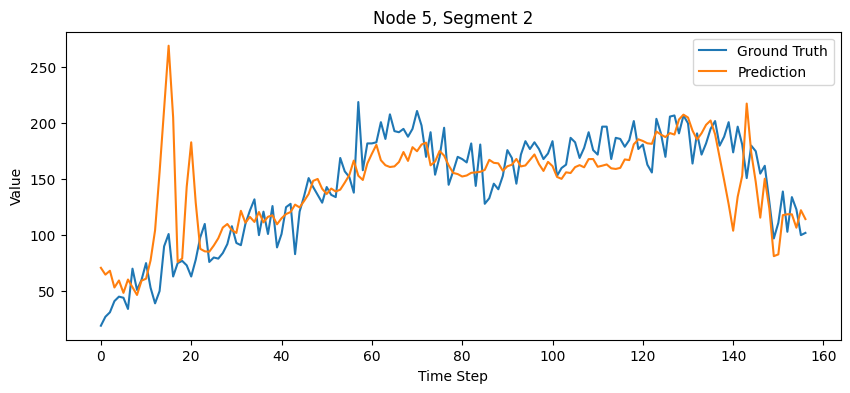

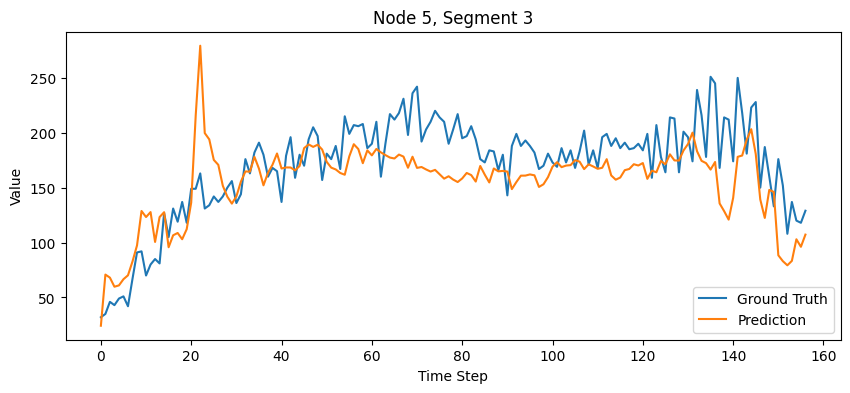

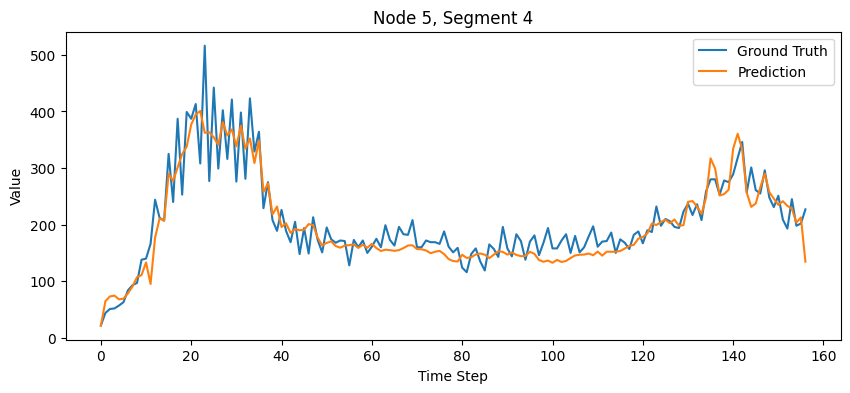

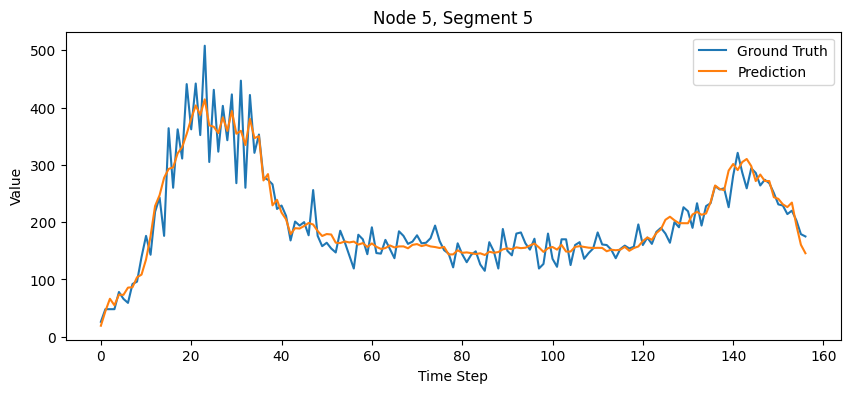

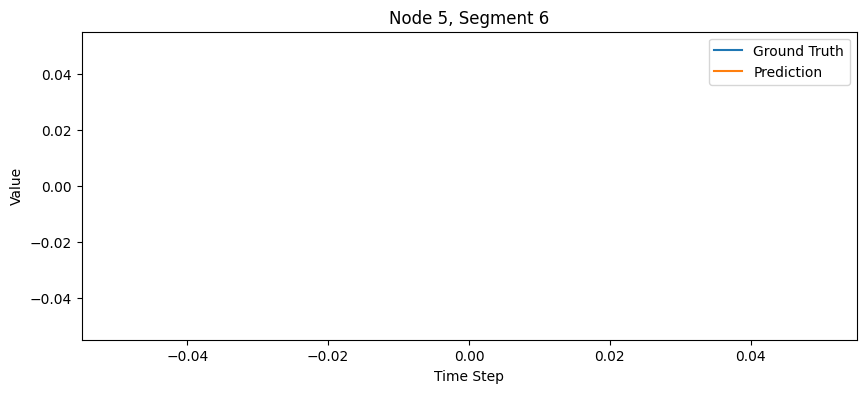

last gt_segment tensor([ 36.,  44.,  71.,  82.,  85.,  76., 107., 116., 130., 123., 171., 200.,
        211., 239., 228., 321., 372., 456., 428., 419., 492., 503., 486., 468.,
        477., 428., 370., 382., 391., 363., 358., 329., 346., 337., 332., 255.,
        250., 227., 235., 254., 225., 245., 246., 228., 245., 282., 259., 281.,
        235., 227., 243., 233., 243., 239., 234., 241., 252., 257., 250., 282.,
        264., 252., 257., 271., 162.,  92., 298., 275., 305., 270., 248., 301.,
        237., 306., 250., 260., 225., 253., 239., 245., 252., 257., 242., 213.,
        247., 211., 235., 210., 229., 230., 226., 216., 199., 223., 233., 221.,
        250., 267., 234.,  77., 183., 249., 237., 215., 241., 238., 225., 224.,
         52., 145., 247.,  78., 140., 262., 224., 214., 232., 237., 273., 267.,
        217., 230.,  59., 152., 282., 308., 292., 270., 257., 314., 255., 352.,
        291., 332., 552., 434., 448., 479., 430., 466., 417., 537., 481., 486.,
        543., 310., 277.

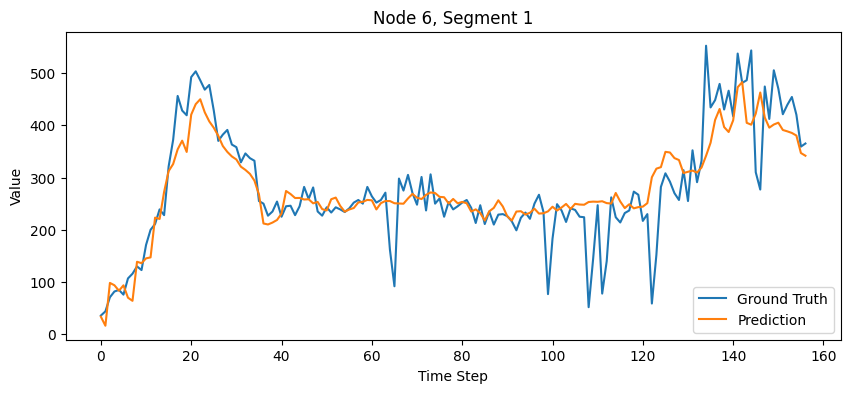

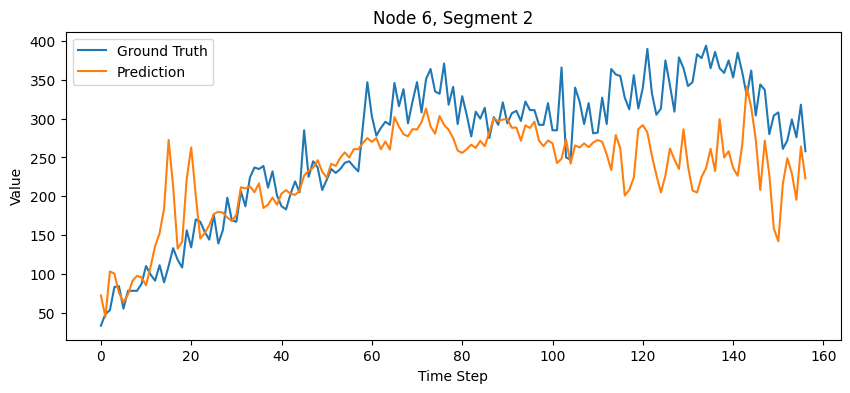

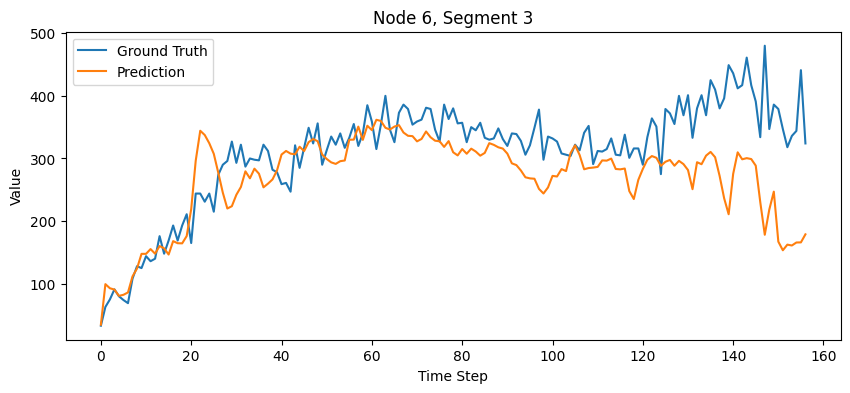

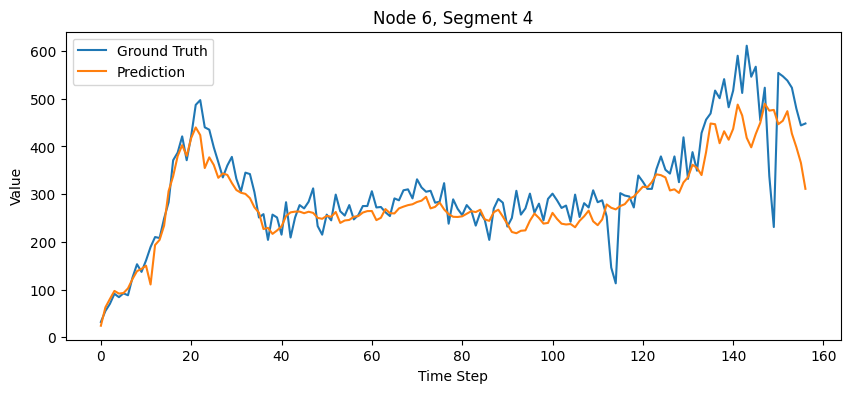

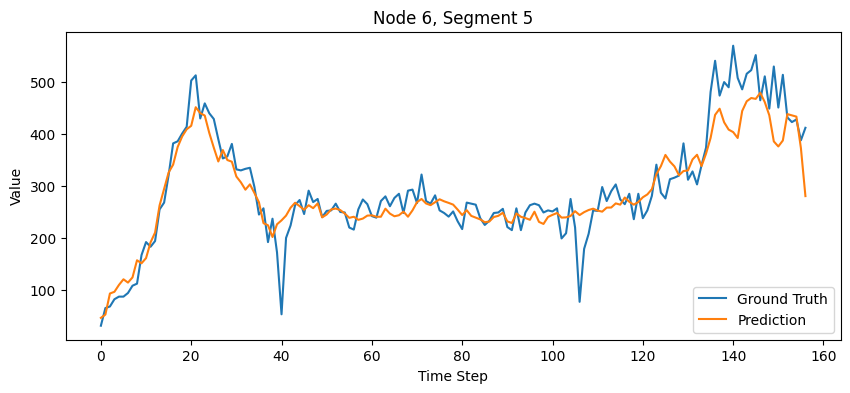

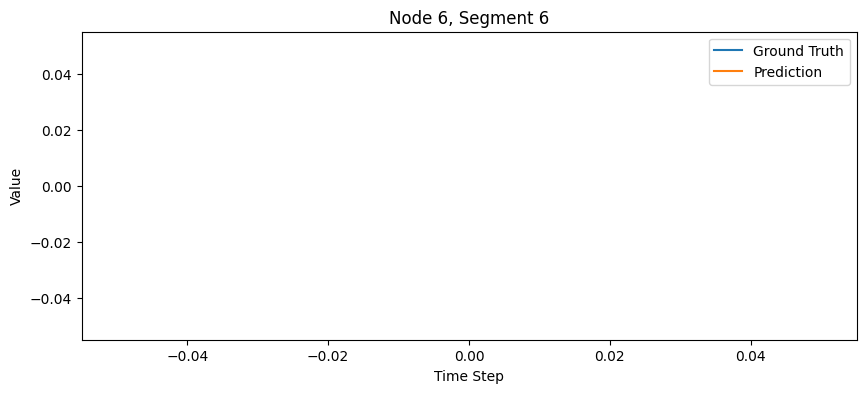

last gt_segment tensor([ 39.,  75.,  63.,  91.,  94.,  92.,  92., 109., 145., 170., 188., 214.,
        223., 261., 241., 346., 343., 359., 463., 462., 477., 418., 435., 449.,
        366., 357., 367., 362., 419., 321., 308., 370., 353., 357., 375., 381.,
        316., 237., 264., 321., 279., 266., 266., 351., 290., 244., 283., 291.,
        275., 266., 269., 302., 269., 267., 257., 272., 281., 260., 288., 300.,
        277., 308., 275., 273., 307., 302., 318., 289., 296., 314., 295., 281.,
        326., 284., 316., 291., 297., 295., 300., 252., 246., 265., 237., 247.,
        250., 236., 253., 241., 246., 340., 461., 305., 220., 261., 235., 263.,
        267., 253., 249., 255., 250., 240., 244., 260., 267., 244., 266., 269.,
        267., 247., 269., 253., 250., 265., 245., 259., 263., 231., 226., 244.,
        224., 228., 256., 256., 288., 241., 318., 304., 203., 268., 240., 257.,
        220., 230., 286., 331., 337., 411., 427., 424., 498., 459., 467., 477.,
        452., 490., 468.

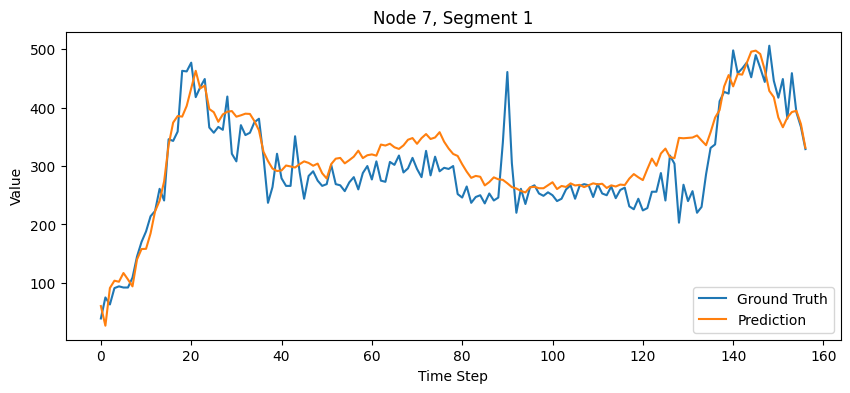

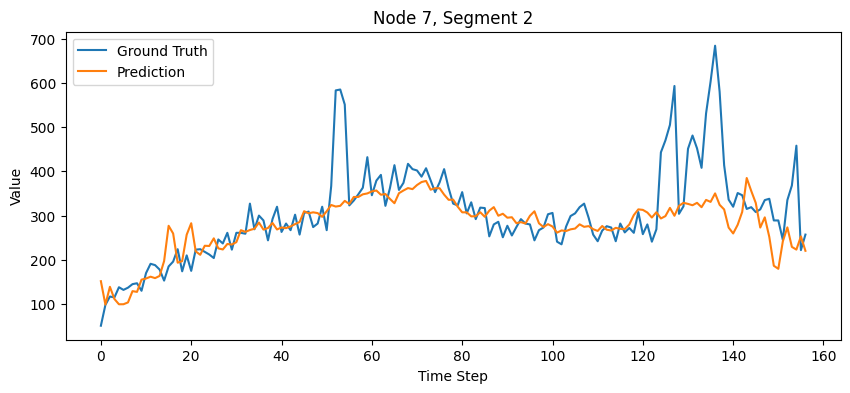

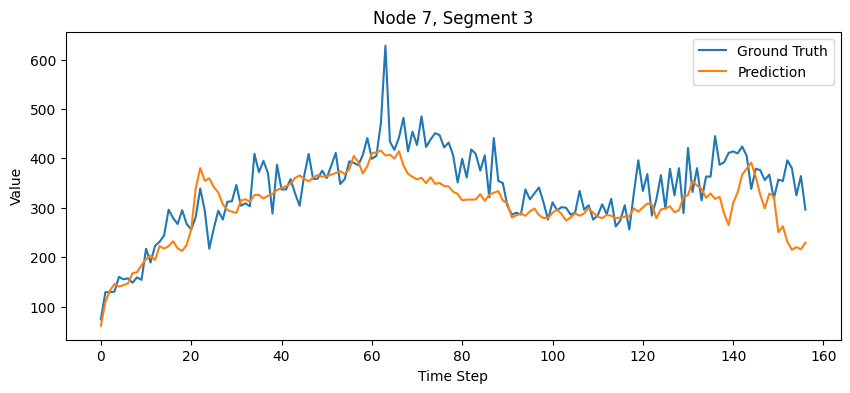

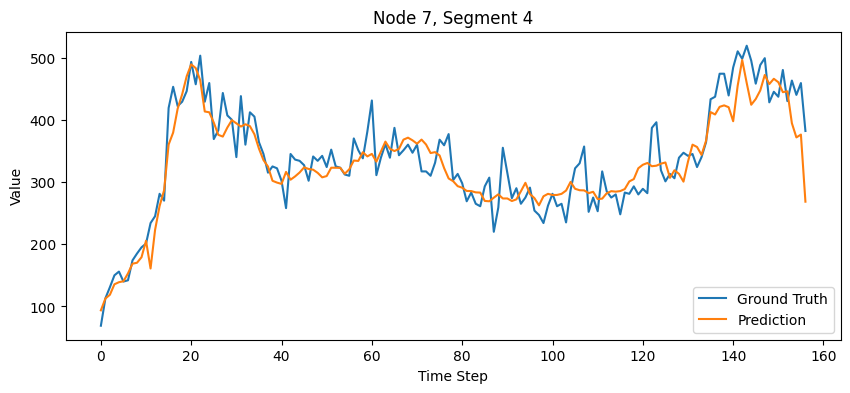

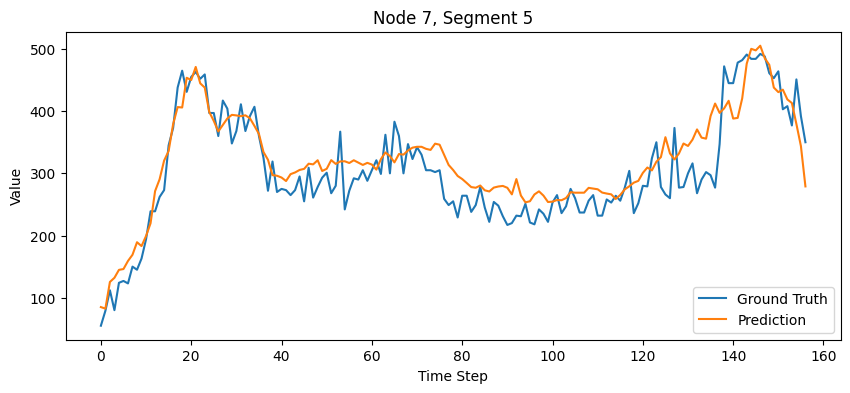

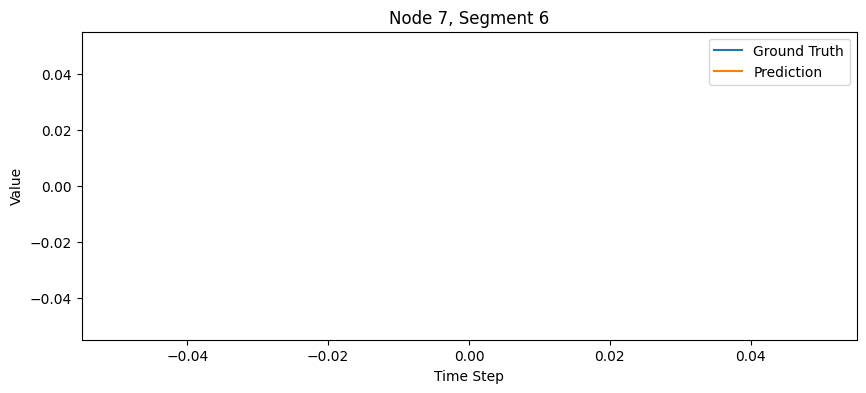

last gt_segment tensor([  1.,   9.,   9.,  11.,  20.,  17.,  14.,  23.,  18.,  42.,  23.,  32.,
         20.,  57.,  59.,  76.,  60.,  77.,  87.,  81., 102.,  89.,  99., 124.,
        122.,  98., 112., 134., 119.,  98., 143.,  80.,  69.,  94.,  82.,  82.,
        108.,  88., 106.,  82.,  65.,  87.,  86.,  65.,  97.,  95.,  90.,  89.,
        107., 114.,  91., 146., 124.,  60., 102.,  84., 106., 100., 124., 111.,
         95., 123., 128.,  98., 119., 132., 125., 152., 123., 140., 138., 135.,
        154.,  91., 150., 138., 139., 161., 126., 114., 131., 146.,  94., 113.,
        124., 127., 153., 104., 161., 117., 167.,  98., 105., 101., 127.,  94.,
         92., 144., 138.,  48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.

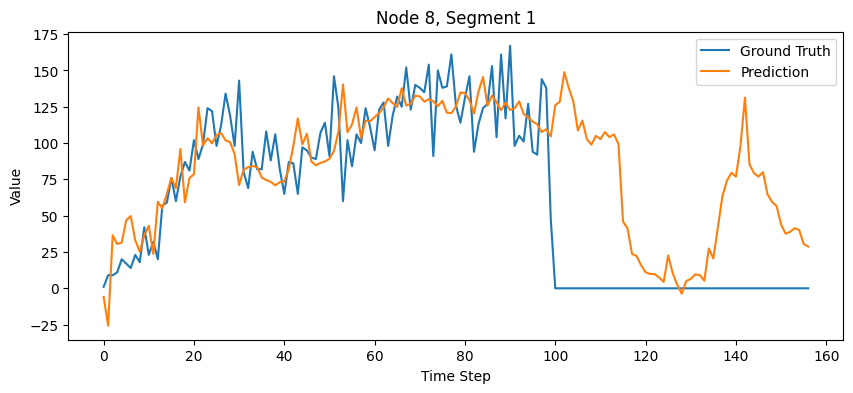

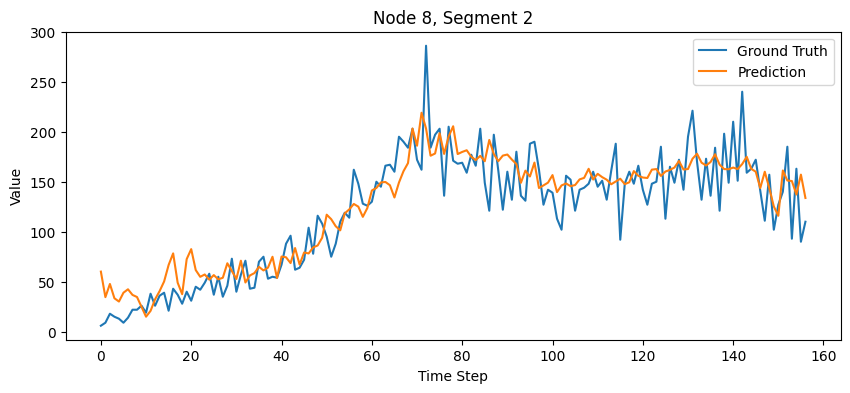

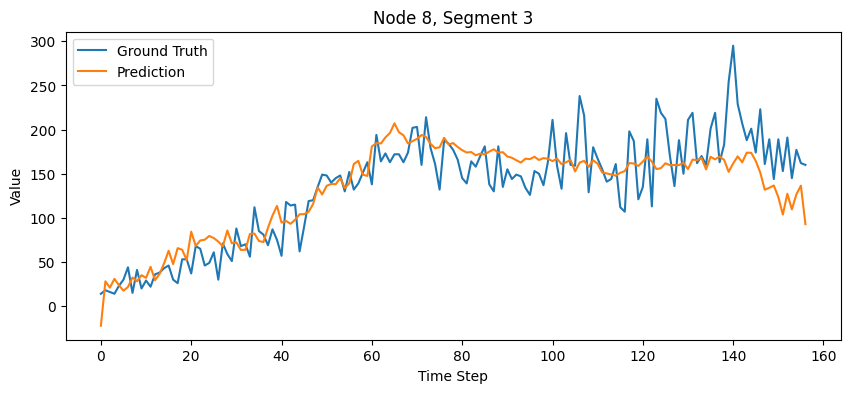

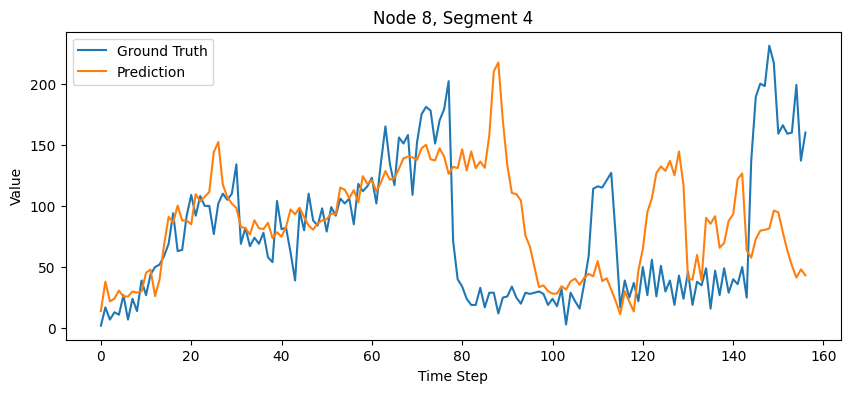

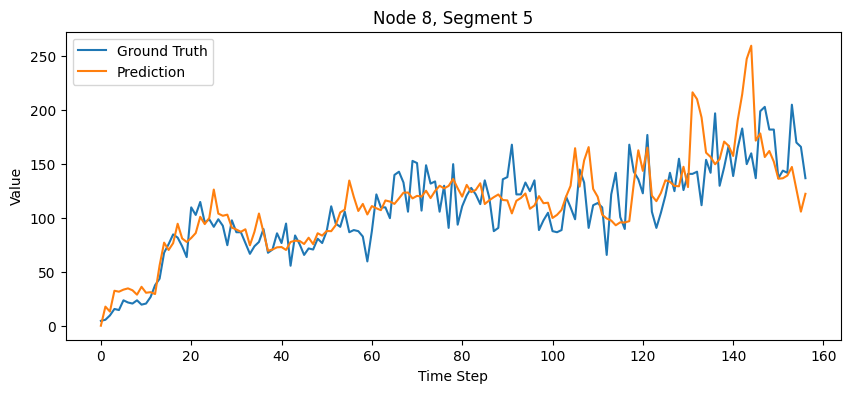

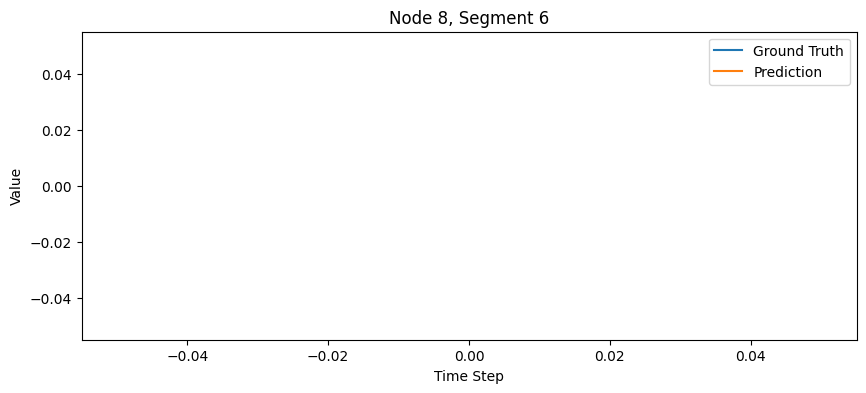

##### exp202312151449_0	 30.08	50.38	0.1308	0.2139	 32.02	52.26	0.1386	0.2383	 32.76	53.19	0.1427	0.2275	 36.38	58.52	0.1602	0.2396	


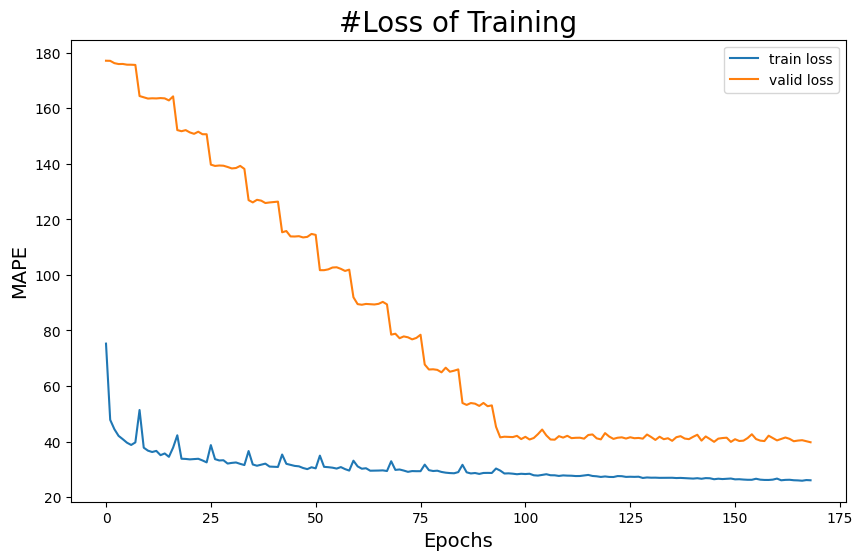



Results


valid	MAE	RMSE	MAPE
mean:	38.4057	65.5511	0.3413
std:	0.0000	0.0000	0.0000



test|horizon	MAE-mean	RMSE-mean	MAPE-mean	MAE-std	RMSE-std	MAPE-std
3	32.0231	52.2591	0.2383	0.0000	0.0000	0.0000
6	32.7569	53.1898	0.2275	0.0000	0.0000	0.0000
12	36.3841	58.5239	0.2396	0.0000	0.0000	0.0000


In [10]:

# test_model(engine,"fusion",dataloader_gct,checkpoint,runid,dataloader_cctv)
def test_model(engine,model_type,dataloader,checkpoint,runid,dataloader2=None):

    ### 測試讀取出的model ###
    valid_loss = []
    valid_mape = []
    valid_rmse = []
    valid_smape = []
    s1 = time.time()

    if dataloader2 != None:
        print("in fusion.................")
        for iter, ((x1, y1), (x2, y2)) in enumerate(zip(dataloader['val_loader'].get_iterator(), dataloader2['val_loader'].get_iterator())):
            # Process data from first loader
            testx1 = torch.Tensor(x1).to(device)
            testx1 = testx1.transpose(1, 3)
            testy1 = torch.Tensor(y1).to(device)
            testy1 = testy1.transpose(1, 3)

            # Process data from second loader
            testx2 = torch.Tensor(x2).to(device)
            testx2 = testx2.transpose(1, 3)
            testy2 = torch.Tensor(y2).to(device)
            testy2 = testy2.transpose(1, 3)

            metrics = engine.eval('fusion',testx1, testy2[:,0,:,:], input_2= testx2)

            valid_loss_2 = []
            valid_mape_2 = []
            valid_rmse_2 = []
            valid_smape_2 = []

            valid_loss.append(metrics[0])
            valid_mape.append(metrics[1])
            valid_rmse.append(metrics[2])
            valid_smape.append(metrics[3])

            valid_loss_2.append(metrics[4])
            valid_mape_2.append(metrics[5])
            valid_rmse_2.append(metrics[6])
            valid_smape_2.append(metrics[7])
    else:
        for iter, (x, y) in enumerate(dataloader['val_loader'].get_iterator()):
            testx = torch.Tensor(x).to(device)
            testx = testx.transpose(1, 3)
            testy = torch.Tensor(y).to(device)
            testy = testy.transpose(1, 3)
            metrics = engine.eval(model_type,testx, testy[:,0,:,:])

            valid_loss.append(metrics[0])
            valid_mape.append(metrics[1])
            valid_rmse.append(metrics[2])
            valid_smape.append(metrics[3])

    mvalid_loss = np.mean(valid_loss)
    mvalid_mape = np.mean(valid_mape)
    mvalid_rmse = np.mean(valid_rmse)
    print("### 2-The valid loss on loding model is", str(round(mvalid_loss,4)))
    if dataloader2 != None:
      print("### 2-The valid(unseen) loss on loding model is", str(round(np.mean(valid_loss_2),4)))
    ### 測試讀取出的model ###


    #valid data
    outputs = []

    if dataloader2 != None:
      realy = torch.Tensor(dataloader2['y_val'+_types]).to(device)
      #realy2 = realy.transpose(1,3)[:,0,:5]
      #print('L59', realy2.shape, realy2[0,:,:2])

      filtered_indices = [index for index in args.all_idx if index not in args.exclue_idx]
      #print('L62', filtered_indices)
      selected_real = realy.transpose(1,3)[:,0,filtered_indices]
      #print('L64',selected_real.shape, selected_real[0,:,:2])
      #sys.exit()

      realy = selected_real
    else:
      realy = torch.Tensor(dataloader['y_val'+_types]).to(device)
      realy = realy.transpose(1,3)[:,0,:,:]
    print('#realy(valid)', realy.shape)

    '''
    for iter, (x, y) in enumerate(dataloader['val_loader'].get_iterator()):
        testx = torch.Tensor(x).to(device)
        testx = testx.transpose(1,3)
        with torch.no_grad():

            if model_type == 'gct':
              preds = engine.model(testx)
            elif model_type == 'cctv':
              preds = engine.model_2(testx)

            preds = preds.transpose(1,3)  # 64,1,6,12

        outputs.append(preds.squeeze()) # 64,1,6,12 ->squeeze()->64,6,12
    '''

    if dataloader2 != None:
        print("in fusion................. 2")
        for iter, ((x1, y1), (x2, y2)) in enumerate(zip(dataloader['val_loader'].get_iterator(), dataloader2['val_loader'].get_iterator())):
            # Process data from first loader
            testx1 = torch.Tensor(x1).to(device)
            testx1 = testx1.transpose(1, 3)

            # Process data from second loader
            testx2 = torch.Tensor(x2).to(device)
            testx2 = testx2.transpose(1, 3)

            with torch.no_grad():  #************#
                '''
                preds = engine.model_3(testx1, idx=None, input_2=testx2)

                preds = preds.transpose(1,3)  # 64,1,6,12
                '''
                # 要先經過model,model_2 encoder #
                output = engine.model(testx1) # cctv
                output = output.transpose(1,3)

                output_2 = engine.model_2(testx2) # cctv
                output_2 = output_2.transpose(1,3)

                output = torch.cat([output,testx1[:,1].unsqueeze(1)],dim=1)
                output_2 = torch.cat([output_2,testx2[:,1].unsqueeze(1)],dim=1)

                preds = engine.model_3(output, idx=None, input_2=output_2)
                preds = preds.transpose(1,3)  # 64,1,6,12


            outputs.append(preds.squeeze()) # 64,1,6,12 ->squeeze()->64,6,12
    else:
        for iter, (x, y) in enumerate(dataloader['val_loader'].get_iterator()):
            testx = torch.Tensor(x).to(device)
            testx = testx.transpose(1,3)
            with torch.no_grad():

                if model_type == 'gct':
                  preds = engine.model(testx)
                elif model_type == 'cctv':
                  preds = engine.model_2(testx)

                preds = preds.transpose(1,3)  # 64,1,6,12

            outputs.append(preds.squeeze()) # 64,1,6,12 ->squeeze()->64,6,12

    yhat = torch.cat(outputs,dim=0)
    yhat = yhat[:realy.size(0),...]  # 5240,6,12

    if dataloader2 != None:
      #indices = torch.tensor([7, 21, 19, 17, 3]).cuda() # The indices you want to select
      #print('L132', indices)

      filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w not in args.exclue_idx]
      indices = torch.tensor(filtered_corre_indices).cuda()
      #print('L136', indices)
      #sys.exit()

      yhat = torch.index_select(yhat, 1, indices)
    print('# cat valid preds', yhat.shape)


    pred = dataloader['scaler'].inverse_transform(yhat)

    vmae, vmape, vrmse,vsmape = metric(pred,realy)
    print("valid vmae",vmae)


    #test data
    outputs = []
    realy = torch.Tensor(dataloader['y_test'+_types]).to(device)
    realy = realy.transpose(1, 3)[:, 0, :, :]


    if dataloader2 != None:
      realy = torch.Tensor(dataloader2['y_test'+_types]).to(device)

      filtered_indices = [index for index in args.all_idx if index not in args.exclue_idx]
      selected_real = realy.transpose(1,3)[:,0,filtered_indices]

      realy_seen = selected_real
      #-----------#
      filtered_indices = [index for index in args.all_idx if index in args.exclue_idx]
      selected_real = realy.transpose(1,3)[:,0,filtered_indices]

      realy_unseen = selected_real
    else:
      realy = torch.Tensor(dataloader['y_test'+_types]).to(device)
      realy = realy.transpose(1,3)[:,0,:,:]
    print('#realy(test)', realy.shape)

    if dataloader2 != None:
        for iter, ((x1, y1), (x2, y2)) in enumerate(zip(dataloader['test_loader'].get_iterator(), dataloader2['test_loader'].get_iterator())):
            # Process data from first loader
            testx1 = torch.Tensor(x1).to(device)
            testx1 = testx1.transpose(1, 3)

            # Process data from second loader
            testx2 = torch.Tensor(x2).to(device)
            testx2 = testx2.transpose(1, 3)
            '''
            with torch.no_grad():
                preds = engine.model_3(testx1, idx=None, input_2=testx2)

                preds = preds.transpose(1,3)  # 64,1,6,12
            '''
            with torch.no_grad():  #************#
                '''
                preds = engine.model_3(testx1, idx=None, input_2=testx2)

                preds = preds.transpose(1,3)  # 64,1,6,12
                '''
                # 要先經過model,model_2 encoder #
                output = engine.model(testx1) # cctv
                output = output.transpose(1,3)

                output_2 = engine.model_2(testx2) # cctv
                output_2 = output_2.transpose(1,3)

                output = torch.cat([output,testx1[:,1].unsqueeze(1)],dim=1)
                output_2 = torch.cat([output_2,testx2[:,1].unsqueeze(1)],dim=1)

                preds = engine.model_3(output, idx=None, input_2=output_2)
                preds = preds.transpose(1,3)  # 64,1,6,12

            outputs.append(preds.squeeze()) # 64,1,6,12 ->squeeze()->64,6,12
    else:
        for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
            testx = torch.Tensor(x).to(device)
            testx = testx.transpose(1, 3)
            with torch.no_grad():
                #preds = engine.model(testx)
                if model_type == 'gct':
                  preds = engine.model(testx)
                elif model_type == 'cctv':
                  preds = engine.model_2(testx)

                preds = preds.transpose(1, 3)
            outputs.append(preds.squeeze())

    yhat = torch.cat(outputs, dim=0)
    yhat = yhat[:realy.size(0), ...]  #10478, 6, 12

    if dataloader2 != None:
      #indices = torch.tensor([7, 21, 19, 17, 3]).cuda() # The indices you want to select
      #print('L218', indices)

      filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w not in args.exclue_idx]
      indices = torch.tensor(filtered_corre_indices).cuda()
      #print('L222', indices)
      #sys.exit()

      #print('L243', yhat.shape)
      yhat_seen = torch.index_select(yhat, 1, indices)
      #print('L245', indices, yhat.shape)
      #------------------#
      filtered_corre_indices = [args.corre_idx[w] for w in range(len(args.corre_idx)) if w in args.exclue_idx]
      indices = torch.tensor(filtered_corre_indices).cuda()

      yhat_unseen = torch.index_select(yhat, 1, indices)


    if dataloader2 != None:
      #------------unseen------------#
      print("#-------------------unseen--------------------#")
      mae = []
      mape = []
      rmse = []
      smape = []
      for i in range(args.seq_out_len):

          pred = dataloader['scaler'].inverse_transform(yhat_unseen[:, :, i])

          real = realy_unseen[:, :, i]
          metrics = metric(pred, real)

          #print(metrics, 'pred', pred.shape , pred[0], 'real', real.shape, real[0])

          log = 'Evaluate best model on test data for horizon {:d}, Test MAE: {:.4f}, Test MAPE: {:.4f}, Test RMSE: {:.4f}'
          print(log.format(i + 1, metrics[0], metrics[1], metrics[2]))
          mae.append(metrics[0])
          mape.append(metrics[1])
          rmse.append(metrics[2])
          smape.append(metrics[3])

          if i==2 or i==5 or i == 11:
              ground_truth = real.cpu()
              predictions = pred.cpu()

              num_samples = ground_truth.size(0)
              nodes = ground_truth.shape[1]
              time_steps_per_chart = 157
              num_charts = num_samples // time_steps_per_chart
              #if num_samples % time_steps_per_chart != 0:
              #    num_charts += 1

              for node in range(nodes):
                for chart_num in range(num_charts):
                    if chart_num == 0:
                        gt_segment = ground_truth[num_samples-(157-(11-i)):num_samples, node]
                        pred_segment = predictions[num_samples-(157-(11-i)):num_samples, node]
                    else:
                        gt_segment = ground_truth[(num_samples-(157-(11-i)))-157*(chart_num):(num_samples-(157-(11-i)))-157*(chart_num-1), node]
                        pred_segment = predictions[(num_samples-(157-(11-i)))-157*(chart_num):(num_samples-(157-(11-i)))-157*(chart_num-1), node]


                    # Reshape for plotting
                    gt_segment = gt_segment.view(-1).numpy()
                    pred_segment = pred_segment.view(-1).numpy()

                    # Create the plot
                    plt.figure(figsize=(10, 4))
                    plt.plot(gt_segment, label='Ground Truth')
                    plt.plot(pred_segment, label='Prediction')
                    plt.title(f'Prediction len {i+1}, Day 9/{26-chart_num}, MAE:{round(metrics[0], 2)}, MAPE:{round(metrics[1], 2)}')
                    plt.xlabel('Time Step')
                    plt.ylabel('Value')
                    plt.legend()
                    plt.show()

                    print("#real", gt_segment)
                    print("#predict", pred_segment)

      log = '{:.2f}	{:.2f}	{:.4f}	{:.4f}	'
      print( "##### exp" + str(args.expid_gct) + "_" + str(runid)+'	',
            log.format(mae[0], rmse[0], smape[0], mape[0]),
            log.format(mae[2], rmse[2], smape[2], mape[2]),
            log.format(mae[5], rmse[5], smape[5], mape[5]),
            log.format(mae[11], rmse[11], smape[11], mape[11]),
          )

      #------------seen------------#
      print("#-------------------seen--------------------#")
      mae = []
      mape = []
      rmse = []
      smape = []
      for i in range(args.seq_out_len):

          pred = dataloader['scaler'].inverse_transform(yhat_seen[:, :, i])

          real = realy_seen[:, :, i]
          metrics = metric(pred, real)

          #print(metrics, 'pred', pred.shape , pred[0], 'real', real.shape, real[0])

          log = 'Evaluate best model on test data for horizon {:d}, Test MAE: {:.4f}, Test MAPE: {:.4f}, Test RMSE: {:.4f}'
          print(log.format(i + 1, metrics[0], metrics[1], metrics[2]))
          mae.append(metrics[0])
          mape.append(metrics[1])
          rmse.append(metrics[2])
          smape.append(metrics[3])

          if i == 11:
              ground_truth = real.cpu()
              predictions = pred.cpu()

              num_samples = ground_truth.size(0)
              nodes = ground_truth.shape[1]
              time_steps_per_chart = 157
              num_charts = num_samples // time_steps_per_chart
              if num_samples % time_steps_per_chart != 0:
                  num_charts += 1

              for node in range(nodes):
                for chart_num in range(num_charts):
                    if chart_num == 0:
                        gt_segment = ground_truth[num_samples-157:, node]
                        pred_segment = predictions[num_samples-157:, node]
                        #print(gt_segment,len(gt_segment))
                        print('last gt_segment', gt_segment)
                    else:
                        gt_segment = ground_truth[num_samples-157*(chart_num+1):num_samples-157*(chart_num), node]
                        pred_segment = predictions[num_samples-157*(chart_num+1):num_samples-157*(chart_num), node]
                        #print(gt_segment,len(gt_segment))


                    # Reshape for plotting
                    gt_segment = gt_segment.view(-1).numpy()
                    pred_segment = pred_segment.view(-1).numpy()

                    # Create the plot
                    plt.figure(figsize=(10, 4))
                    plt.plot(gt_segment, label='Ground Truth')
                    plt.plot(pred_segment, label='Prediction')
                    plt.title(f'Node {node+1}, Segment {chart_num+1}')
                    plt.xlabel('Time Step')
                    plt.ylabel('Value')
                    plt.legend()
                    plt.show()

      log = '{:.2f}	{:.2f}	{:.4f}	{:.4f}	'
      print( "##### exp" + str(args.expid_gct) + "_" + str(runid)+'	',
            log.format(mae[0], rmse[0], smape[0], mape[0]),
            log.format(mae[2], rmse[2], smape[2], mape[2]),
            log.format(mae[5], rmse[5], smape[5], mape[5]),
            log.format(mae[11], rmse[11], smape[11], mape[11]),
          )
    else:
      mae = []
      mape = []
      rmse = []
      smape = []
      for i in range(args.seq_out_len):

          pred = dataloader['scaler'].inverse_transform(yhat[:, :, i])

          real = realy[:, :, i]
          metrics = metric(pred, real)

          #print(metrics, 'pred', pred.shape , pred[0], 'real', real.shape, real[0])

          log = 'Evaluate best model on test data for horizon {:d}, Test MAE: {:.4f}, Test MAPE: {:.4f}, Test RMSE: {:.4f}'
          print(log.format(i + 1, metrics[0], metrics[1], metrics[2]))
          mae.append(metrics[0])
          mape.append(metrics[1])
          rmse.append(metrics[2])
          smape.append(metrics[3])

      log = '{:.2f}	{:.2f}	{:.4f}	{:.4f}	'
      print( "##### exp" + str(args.expid_gct) + "_" + str(runid)+'	',
            log.format(mae[0], rmse[0], smape[0], mape[0]),
            log.format(mae[2], rmse[2], smape[2], mape[2]),
            log.format(mae[5], rmse[5], smape[5], mape[5]),
            log.format(mae[11], rmse[11], smape[11], mape[11]),
          )

    ### Drawing Loss Diagram ###
    fig = plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(checkpoint['train_loss'], label="train loss")
    plt.plot(checkpoint['valid_loss'], label="valid loss")
    plt.legend(loc="upper right")
    plt.title('#Loss of Training', fontsize=20)
    plt.ylabel("MAPE", fontsize=14)
    plt.xlabel("Epochs", fontsize=14)
    plt.show()

    return vmae, vmape, vrmse,vsmape, mae, mape, rmse,smape

def main(runid):


    # if args.load_static_feature:
    #     static_feat = load_node_feature('data/sensor_graph/location.csv')
    # else:
    #     static_feat = None

    # num_nodes, subgraph_size, adj_mx
    model = gginet(args.model_type, args.gcn_true, args.buildA_true, args.gcn_depth,
                   args.num_nodes_gct, #********#
                   device,
                   predefined_A=adj_mx_gct,
                   kernel_set=args.kernel_set, dropout=args.dropout,
                   subgraph_size=args.subgraph_size_gct,  #********#
                   node_dim=args.node_dim, dilation_exponential=args.dilation_exponential, conv_channels=args.conv_channels, residual_channels=args.residual_channels,
                  skip_channels=args.skip_channels, end_channels= args.end_channels,
                  seq_length=args.seq_in_len, in_dim=args.in_dim, out_dim=args.seq_out_len,
                  layers=args.layers, propalpha=args.propalpha, tanhalpha=args.tanhalpha, layer_norm_affline=True)

    model_cctv = gginet(args.model_type, args.gcn_true, args.buildA_true, args.gcn_depth,
                   args.num_nodes_cctv, #********#
                   device,
                   predefined_A=adj_mx_cctv,
                   kernel_set=args.kernel_set, dropout=args.dropout,
                   subgraph_size=args.subgraph_size_cctv, #********#
                   node_dim=args.node_dim, dilation_exponential=args.dilation_exponential, conv_channels=args.conv_channels, residual_channels=args.residual_channels,
                  skip_channels=args.skip_channels, end_channels= args.end_channels,
                  seq_length=args.seq_in_len, in_dim=args.in_dim, out_dim=args.seq_out_len,
                  layers=args.layers, propalpha=args.propalpha, tanhalpha=args.tanhalpha, layer_norm_affline=True)

    model_fusion = gginet(args.model_type, args.gcn_true, args.buildA_true, args.gcn_depth,
                   args.num_nodes_gct, #********#
                   device,
                   predefined_A=adj_mx_gct,
                   kernel_set=args.kernel_set, dropout=args.dropout,
                   subgraph_size=args.subgraph_size_gct,  #********#
                   node_dim=args.node_dim, dilation_exponential=args.dilation_exponential, conv_channels=args.conv_channels, residual_channels=args.residual_channels,
                  skip_channels=args.skip_channels, end_channels= args.end_channels,
                  seq_length=args.seq_in_len, in_dim=args.in_dim, out_dim=args.seq_out_len,
                  layers=args.layers, propalpha=args.propalpha, tanhalpha=args.tanhalpha, layer_norm_affline=True, fusion=1)

    print(model)
    print(args)

    print('The recpetive field size is', model.receptive_field)
    nParams = sum([p.nelement() for p in model.parameters()])       # model參數量!
    print('Number of model parameters is', nParams)

    engine = Trainer(model, model_cctv,model_fusion, args.learning_rate, args.weight_decay, args.clip, args.step_size1, args.seq_out_len, dataloader_gct['scaler'], dataloader_cctv['scaler'], device, args.cl)

    ###############
    #.............#
    ###############

    # expid_gct
    SAVE_PATH = args.save + "exp" + str(args.expid_gct) + "_" + str(runid) +".pth"
    print("### loading model is:",SAVE_PATH ,'###')
    checkpoint = torch.load(SAVE_PATH)
    engine.model.load_state_dict(checkpoint['model_state_dict'])
    engine.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    print("### Loading Model finished ###")
    print("### The valid loss on loding model is", str(round(loss,4)))

    # expid_cctv
    SAVE_PATH = args.save + "exp" + str(args.expid_cctv) + "_" + str(runid) +".pth"
    print("### loading model is:",SAVE_PATH ,'###')
    checkpoint = torch.load(SAVE_PATH)
    engine.model_2.load_state_dict(checkpoint['model_state_dict'])
    engine.optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    print("### Loading Model finished ###")
    print("### The valid loss on loding model is", str(round(loss,4)))

    #-----------------------Training--------------------#

    print("start training...",flush=True)
    his_loss =[]
    val_time = []
    train_time = []
    minl = 1e5
    start_epoch=0
    SAVE_PATH = ""
    train_loss_epoch = []  # 紀錄train在epoch收斂
    valid_loss_epoch = []  # 紀錄valid在epoch收斂

    for i in range(start_epoch,start_epoch+args.epochs+1):

        train_loss_gct = []
        train_loss = []
        train_mape = []
        train_rmse = []
        train_smape = []

        ### unseen ###
        train_loss_2 = []
        train_mape_2 = []
        train_rmse_2 = []
        train_smape_2 = []

        t1 = time.time()

        permutation = np.random.permutation(dataloader_gct['train_loader'].size)
        dataloader_gct['train_loader'].set_permutation(permutation)
        dataloader_cctv['train_loader'].set_permutation(permutation)

        for iter, ((x1, y1), (x2, y2)) in enumerate(zip(dataloader_gct['train_loader'].get_iterator(), dataloader_cctv['train_loader'].get_iterator())):
            # Process data from first loader (GCT)
            trainx1 = torch.Tensor(x1).to(device)
            trainx1 = trainx1.transpose(1, 3)
            trainy1 = torch.Tensor(y1).to(device)
            trainy1 = trainy1.transpose(1, 3)

            # Process data from second loader (CCTV)
            trainx2 = torch.Tensor(x2).to(device)
            trainx2 = trainx2.transpose(1, 3)
            trainy2 = torch.Tensor(y2).to(device)
            trainy2 = trainy2.transpose(1, 3)

            # 目標仍是predict GCT
            metrics = engine.train(trainx1,trainx2, trainy1[:,0,:,:], trainy2[:,0,:,:])

            train_loss_gct.append(metrics[0])
            train_loss.append(metrics[1])
            train_mape.append(metrics[2])
            train_rmse.append(metrics[3])
            train_smape.append(metrics[4])

            train_loss_2.append(metrics[5])
            train_mape_2.append(metrics[6])
            train_rmse_2.append(metrics[7])
            train_smape_2.append(metrics[8])

            #if iter % args.print_every == 0 :
            #    log = 'Train Iter: {:03d}, [Seen] MAE: {:.4f}, MAPE: {:.4f}, RMSE: {:.4f}, [Unseen] MAE: {:.4f}, MAPE: {:.4f}, RMSE: {:.4f}'
            #    print(log.format(iter, train_loss[-1], train_mape[-1], train_rmse[-1], train_loss_2[-1], train_mape_2[-1], train_smape_2[-1]),flush=True)

        t2 = time.time()
        train_time.append(t2-t1)
        #validation
        valid_loss = []
        valid_mape = []
        valid_rmse = []
        valid_smape = []

        valid_loss_2 = []
        valid_mape_2 = []
        valid_rmse_2 = []
        valid_smape_2 = []

        s1 = time.time()


        for iter, ((x1, y1), (x2, y2)) in enumerate(zip(dataloader_gct['val_loader'].get_iterator(), dataloader_cctv['val_loader'].get_iterator())):
            # Process data from first loader (GCT)
            testx1 = torch.Tensor(x1).to(device)
            testx1 = testx1.transpose(1, 3)
            testy1 = torch.Tensor(y1).to(device)
            testy1 = testy1.transpose(1, 3)

            # Process data from second loader (CCTV)
            testx2 = torch.Tensor(x2).to(device)
            testx2 = testx2.transpose(1, 3)
            testy2 = torch.Tensor(y2).to(device)
            testy2 = testy2.transpose(1, 3)

            metrics = engine.eval('fusion',testx1, testy2[:,0,:,:], input_2= testx2)

            valid_loss.append(metrics[0])
            valid_mape.append(metrics[1])
            valid_rmse.append(metrics[2])
            valid_smape.append(metrics[3])

            valid_loss_2.append(metrics[4])
            valid_mape_2.append(metrics[5])
            valid_rmse_2.append(metrics[6])
            valid_smape_2.append(metrics[7])

        s2 = time.time()
        log = 'Epoch: {:03d}, Inference Time: {:.4f} secs'
        print(log.format(i,(s2-s1)))
        val_time.append(s2-s1)


        mtrain_loss_gct = np.mean(train_loss_gct)
        mtrain_loss = np.mean(train_loss)
        mtrain_mape = np.mean(train_mape)
        mtrain_rmse = np.mean(train_rmse)
        mtrain_smape = np.mean(train_smape)

        mvalid_loss = np.mean(valid_loss)
        mvalid_mape = np.mean(valid_mape)
        mvalid_rmse = np.mean(valid_rmse)
        mvalid_smape = np.mean(valid_smape)
        his_loss.append(mtrain_loss)
        #-------------#
        mtrain_loss_2 = np.mean(train_loss_2)
        mtrain_mape_2 = np.mean(train_mape_2)
        mtrain_rmse_2 = np.mean(train_rmse_2)
        mtrain_smape_2 = np.mean(train_smape_2)

        mvalid_loss_2 = np.mean(valid_loss_2)
        mvalid_mape_2 = np.mean(valid_mape_2)
        mvalid_rmse_2 = np.mean(valid_rmse_2)
        mvalid_smape_2 = np.mean(valid_smape_2)

        w1_value = model_fusion.W_f1.item()
        w2_value = model_fusion.W_f2.item()

        log = 'Training Epoch: {:03d}, [Seen] MAE(GCT): {:.4f}, MAE: {:.4f}, MAPE: {:.4f}, RMSE: {:.4f} || Valid MAE: {:.4f}, MAPE: {:.4f}, RMSE: {:.4f}'
        print(log.format(i, mtrain_loss_gct, mtrain_loss, mtrain_mape, mtrain_rmse, mvalid_loss, mvalid_mape, mvalid_rmse ),flush=True)

        log = 'Training Epoch: {:03d}, [Unseen] MAE: {:.4f}, MAPE: {:.4f}, RMSE: {:.4f} || Valid MAE: {:.4f}, MAPE: {:.4f}, RMSE: {:.4f}'
        print(log.format(i, mtrain_loss_2, mtrain_mape_2, mtrain_rmse_2, mvalid_loss_2, mvalid_mape_2, mvalid_rmse_2),flush=True)

        log = 'Training w1: {:.7f}, w2: {:.7f}, Training Time: {:.4f}/epoch'
        print(log.format(w1_value, w2_value, (t2 - t1)),flush=True)

        # 紀錄每個epoch的loss
        train_loss_epoch.append(mtrain_loss)
        valid_loss_epoch.append(mvalid_loss)

        if mvalid_loss<minl:
            #torch.save(engine.model.state_dict(), args.save + "exp" + str(args.expid) + "_" + str(runid) +".pth")
            SAVE_PATH = args.save + "exp" + str(args.expid_fusion) + "_" + str(runid) +".pth"
            print("### Update Best Model:",SAVE_PATH, " ###")
            torch.save({
              'epoch': i,
              'task_level': engine.task_level,
              'model_state_dict': engine.model_3.state_dict(),   #*******#
              'optimizer_state_dict': engine.optimizer_3.state_dict(), #*******#
              'loss': mvalid_loss,
              'train_loss': train_loss_epoch,
              'valid_loss': valid_loss_epoch
            }, SAVE_PATH)
            minl = mvalid_loss

    print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
    print("Average Inference Time: {:.4f} secs".format(np.mean(val_time)))


    bestid = np.argmin(his_loss)

    writer.close()
    print("Training finished")
    print("The valid loss on best model is", str(round(his_loss[bestid],4)))

    #-----------------------Training-------------------#

    print("--------------------CCTV------------------")
    vmae, vmape, vrmse,vsmape, mae, mape, rmse,smape = test_model(engine,"cctv",dataloader_cctv,checkpoint,runid)
    print("--------------------GCT------------------")
    vmae, vmape, vrmse,vsmape, mae, mape, rmse,smape = test_model(engine,"gct",dataloader_gct,checkpoint,runid)
    print("--------------------Fusion------------------")
    # expid_cctv
    SAVE_PATH = args.save + "exp" + str(args.expid_fusion) + "_" + str(runid) +".pth"
    print("### loading model is:",SAVE_PATH ,'###')
    checkpoint = torch.load(SAVE_PATH)
    engine.model_3.load_state_dict(checkpoint['model_state_dict'])   #*******#
    engine.optimizer_3.load_state_dict(checkpoint['optimizer_state_dict']) #*******#
    loss = checkpoint['loss']
    print("### Loading Model finished ###")
    print("### The valid loss on loding model is", str(round(loss,4)))
    vmae, vmape, vrmse,vsmape, mae, mape, rmse,smape = test_model(engine,"fusion",dataloader_gct,checkpoint,runid,dataloader_cctv)

    #sys.exit()

    return vmae, vmape, vrmse,vsmape, mae, mape, rmse,smape


if __name__ == "__main__":

    vmae = []
    vmape = []
    vrmse = []
    vsmape = []
    mae = []
    mape = []
    rmse = []
    smape = []
    for i in range(args.runs):
        vm1, vm2, vm3,vm4, m1, m2, m3, m4 = main(i)
        vmae.append(vm1)
        vmape.append(vm2)
        vrmse.append(vm3)
        vsmape.append(vm4)
        mae.append(m1)
        mape.append(m2)
        rmse.append(m3)
        smape.append(m4)

    mae = np.array(mae)
    mape = np.array(mape)
    rmse = np.array(rmse)
    smape = np.array(smape)

    amae = np.mean(mae,0)
    amape = np.mean(mape,0)
    armse = np.mean(rmse,0)
    asmape = np.mean(smape,0)

    smae = np.std(mae,0)
    s_mape = np.std(mape,0)
    srmse = np.std(rmse,0)
    s_smape = np.std(smape,0)

    print('\n\nResults\n\n')
    #valid data
    print('valid\tMAE\tRMSE\tMAPE')
    log = 'mean:\t{:.4f}\t{:.4f}\t{:.4f}'
    print(log.format(np.mean(vmae),np.mean(vrmse),np.mean(vmape)))
    log = 'std:\t{:.4f}\t{:.4f}\t{:.4f}'
    print(log.format(np.std(vmae),np.std(vrmse),np.std(vmape)))
    print('\n\n')
    #test data
    print('test|horizon\tMAE-mean\tRMSE-mean\tMAPE-mean\tMAE-std\tRMSE-std\tMAPE-std')
    for i in [2,5,11]:
        log = '{:d}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'
        print(log.format(i+1, amae[i], armse[i], amape[i], smae[i], srmse[i], s_mape[i]))
